In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn.cluster import KMeans
import tqdm
from tqdm.notebook import tqdm_notebook
import os.path
from pptx import Presentation
from sklearn.preprocessing import MinMaxScaler
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import kaleido
import plotly.express as px
import plotly.io as pio
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
%matplotlib inline

In [2]:
# load using pandas
df=pd.read_csv("/Users/rebeccaharrison/Documents/Python/Bootcamp/Data/country_data/Country-data.csv")
dictionary=pd.read_csv("/Users/rebeccaharrison/Documents/Python/Bootcamp/Data/country_data/data-dictionary.csv")
df.rename(columns={'child_mort': 'Under 5 mortality','exports':'Exports','imports':'Imports','health':'Health spending per capita','inflation':'Inflation', 'income': 'Net income per person','life_expec':'Life expectancy','total_fer':'Fertility rate','gdpp':'GDP per capita'}, inplace=True)
dictionary

Column Name                                        Description
0     country                                Name of the country
1  child_mort  Death of children under 5 years of age per 100...
2     exports  Exports of goods and services per capita. Give...
3      health  Total health spending per capita. Given as %ag...
4     imports  Imports of goods and services per capita. Give...
5      Income                              Net income per person
6   Inflation  The measurement of the annual growth rate of t...
7  life_expec  The average number of years a new born child w...
8   total_fer  The number of children that would be born to e...
9        gdpp  The GDP per capita. Calculated as the Total GD...

In [3]:
# No null data here
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   country                     167 non-null    object 
 1   Under 5 mortality           167 non-null    float64
 2   Exports                     167 non-null    float64
 3   Health spending per capita  167 non-null    float64
 4   Imports                     167 non-null    float64
 5   Net income per person       167 non-null    int64  
 6   Inflation                   167 non-null    float64
 7   Life expectancy             167 non-null    float64
 8   Fertility rate              167 non-null    float64
 9   GDP per capita              167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [4]:
df.describe()

Under 5 mortality     Exports  Health spending per capita     Imports  \
count         167.000000  167.000000                  167.000000  167.000000   
mean           38.270060   41.108976                    6.815689   46.890215   
std            40.328931   27.412010                    2.746837   24.209589   
min             2.600000    0.109000                    1.810000    0.065900   
25%             8.250000   23.800000                    4.920000   30.200000   
50%            19.300000   35.000000                    6.320000   43.300000   
75%            62.100000   51.350000                    8.600000   58.750000   
max           208.000000  200.000000                   17.900000  174.000000   

       Net income per person   Inflation  Life expectancy  Fertility rate  \
count             167.000000  167.000000       167.000000      167.000000   
mean            17144.688623    7.781832        70.555689        2.947964   
std             19278.067698   10.570704         8.893172        1.513848   
min               609.000000   -4.210000        32.100000        1.150000   
25%              3355.000000    1.810000        65.300000        1.795000   
50%              9960.000000    5.390000        73.100000        2.410000   
75%             22800.000000   10.750000        76.800000        3.880000   
max            125000.000000  104.000000        82.800000        7.490000   

       GDP per capita  
count      167.000000  
mean     12964.155689  
std      18328.704809  
min        231.000000  
25%       1330.000000  
50%       4660.000000  
75%      14050.000000  
max     105000.000000

In [5]:
# checks for duplicates
print(df.duplicated().any())
print(df.iloc[:,0].duplicated().any())

False
False


In [6]:

df.head()

country  Under 5 mortality  Exports  \
0          Afghanistan               90.2     10.0   
1              Albania               16.6     28.0   
2              Algeria               27.3     38.4   
3               Angola              119.0     62.3   
4  Antigua and Barbuda               10.3     45.5   

   Health spending per capita  Imports  Net income per person  Inflation  \
0                        7.58     44.9                   1610       9.44   
1                        6.55     48.6                   9930       4.49   
2                        4.17     31.4                  12900      16.10   
3                        2.85     42.9                   5900      22.40   
4                        6.03     58.9                  19100       1.44   

   Life expectancy  Fertility rate  GDP per capita  
0             56.2            5.82             553  
1             76.3            1.65            4090  
2             76.5            2.89            4460  
3             60.1            6.16            3530  
4             76.8            2.13           12200

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1599: UserWarning:

Vertical orientation ignored with only `x` specified.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1599: UserWarning:

Vertical orientation ignored with only `x` specified.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1599: UserWarning:

Vertical orientation ignored with only `x` specified.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1599: UserWarning:

Vertical orientation ignored with only `x` specified.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1599: UserWarning:

Vertical orientation ignored with only `x` specified.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1599: UserWarning:

Verti

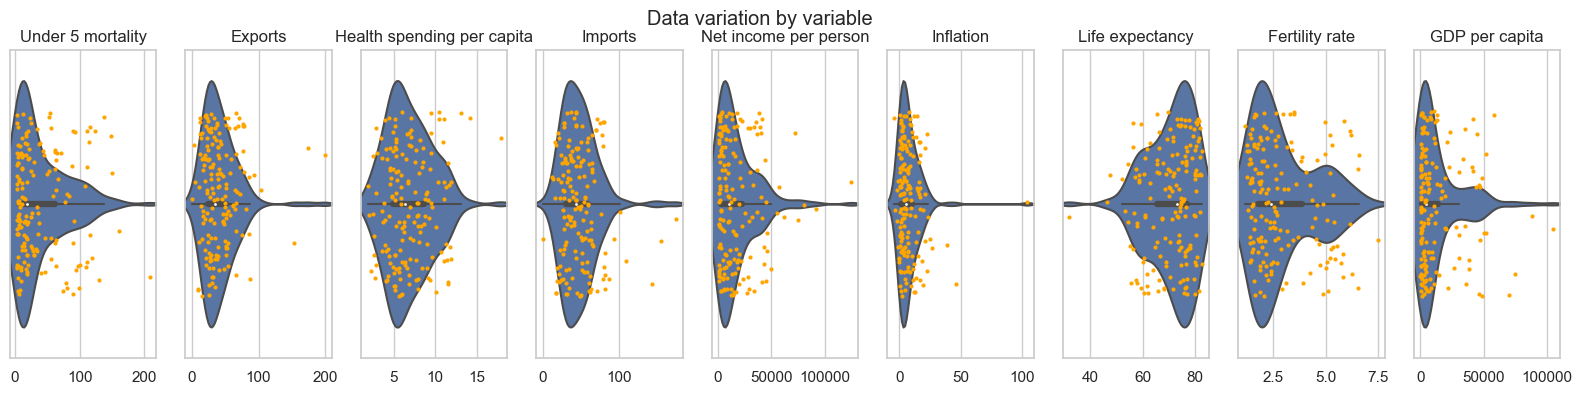

In [44]:
#lots of skew data
fig, ax = plt.subplots(1, 9, sharey=False, figsize=[20, 4])
variables = list(df.iloc[:,1:10].columns)

fig.suptitle('Data variation by variable')

i=0
for var in variables:
    sns.violinplot(x=var, data=df, ax=ax[i],orient="v")
    sns.stripplot(x=var,data=df, color="orange",s = 3,jitter=0.3,ax=ax[i],orient="v")
    ax[i].set_title(var)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
   
    
    i+=1
plt.savefig('/Users/rebeccaharrison/Documents/Python/Bootcamp/Output/Graphs/unsupervised_violin.png')
plt.show()



/var/folders/w3/j_v3f_rs4hlbh_rnzsc6j2rm0000gn/T/ipykernel_95489/2744456253.py:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True)


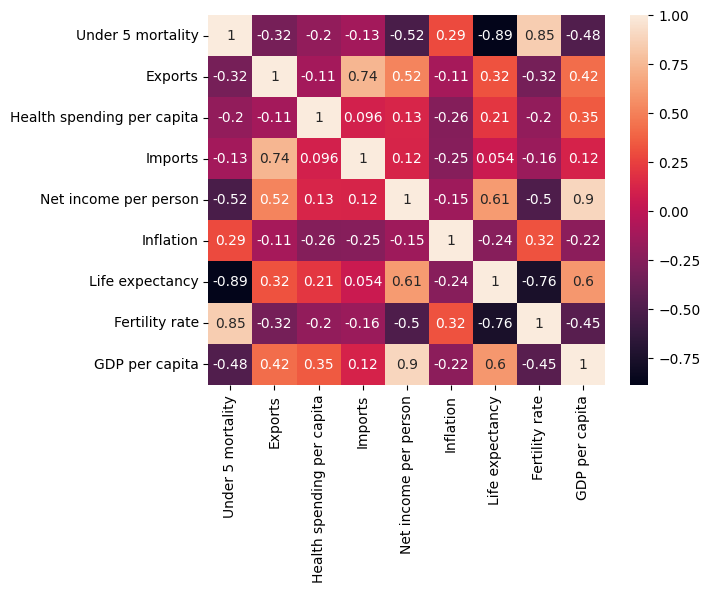

<Figure size 1000x500 with 0 Axes>

In [8]:
# loop to look at all scatter plots
#for i in list(df.iloc[:,1:10].columns):
#    for j in list(df.iloc[:,1:10].columns):
#        if i!=j :
#            plt.scatter(df[i],df[j])
#            plt.xlabel(i)
#            plt.ylabel(j)
#            plt.figure(figsize=(1,1))
#            plt.show()

# could use seaborn heatmap to display this
sns.heatmap(df.corr(),annot=True)
plt.figure(figsize=(10,5))
plt.savefig('/Users/rebeccaharrison/Documents/Python/Bootcamp/Output/Graphs/unsupervised_corr.png')
plt.show()

# there are several that are highly correlated so could be removed for simplicity:
#total_fer and child_mort
#total_fer and life_expec
#child_mort and life_expec

#could therefore include child_mort only

#exports and imports are correlated

#income and gdpp are highly correlated

# could therefore include child_mort, gdpp, exports as the first three variables in the model

In [9]:
# Scaling the data (#)
scaler_X = MinMaxScaler() # this is often a really good one to use, but the industry standard is the standard scaler
df_scaled = scaler_X.fit_transform(df.iloc[:,1:10]) # Scaling  data

# Creating a version of the dataset where health, export and import are removed
df_small = scaler_X.fit_transform(df.iloc[:,[1,5,6,7,8,9]])

[42.79871877568752, 25.947360933529875, 19.345118591450642, 16.781002591696126, 15.163455635536096, 13.820609723167102, 12.382878166482099, 11.692600703604358, 10.901517377612299, 10.205821389279881]


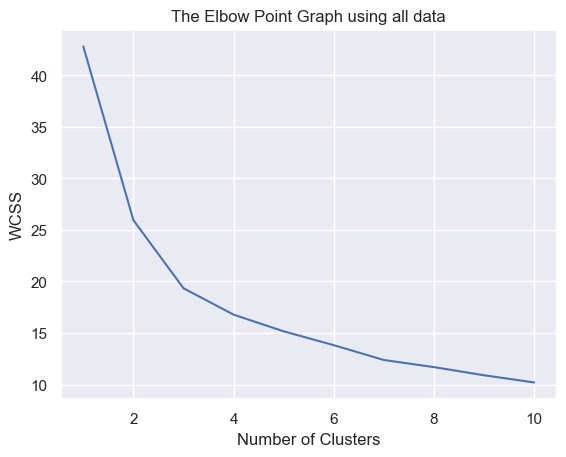

[31.622993954957714, 15.075139486661884, 9.315191545604687, 7.513210674463463, 6.548140068838519, 5.788511152026471, 4.9855622079113715, 4.6563391543825885, 4.055083938320488, 3.762895007657362]


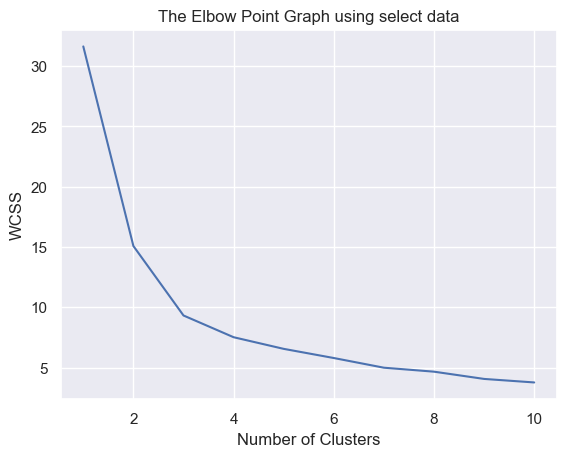

In [10]:
# Doing the elbow graphs to find the right number of cluster

Wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i,init='k-means++',random_state=9)
    kmeans.fit(df_scaled)
    Wcss.append(kmeans.inertia_)
print(Wcss)

sns.set()
plt.plot(range(1,11),Wcss)
plt.title('The Elbow Point Graph using all data')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.savefig('/Users/rebeccaharrison/Documents/Python/Bootcamp/Output/Graphs/unsupervised_elbow2.png')
plt.show()

#Looks like 3 clusters is optimal when all data is included but could also maybe try 4

Wcss=[]
for i in range(1,11):
    kmeans=KMeans(n_clusters=i,init='k-means++',random_state=9)
    kmeans.fit(df_small)
    Wcss.append(kmeans.inertia_)
print(Wcss)

sns.set()
plt.plot(range(1,11),Wcss)
plt.title('The Elbow Point Graph using select data')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.savefig('/Users/rebeccaharrison/Documents/Python/Bootcamp/Output/Graphs/unsupervised_elbow1.png')
plt.show()

# looks v similar to the above

In [11]:
# creating the k means model with 3 clusters on full data
kmeans3=KMeans(n_clusters=3,init='k-means++',random_state=0)
cluster3=kmeans3.fit_predict(df_scaled)

# Trying the k means model with 4 clusters on full data
kmeans4=KMeans(n_clusters=4,init='k-means++',random_state=0)
cluster4=kmeans4.fit_predict(df_scaled)

# Trying the k means model with 2 clusters on full data
kmeans2=KMeans(n_clusters=2,init='k-means++',random_state=0)
cluster2=kmeans2.fit_predict(df_scaled)

#
df['cluster3']=cluster3
df['cluster4']=cluster4
df['cluster2']=cluster2

df['clusterfinal']=""
df['clusterfinal'].loc[df['cluster3'] == 2 ]= 'Richest'
df['clusterfinal'].loc[df['cluster3'] == 1 ]= 'Medium'
df['clusterfinal'].loc[df['cluster3'] == 0 ]='Poorest'

df['cluster4'].loc[df['cluster4'] == 0 ]= 'Poorest'
df['cluster4'].loc[df['cluster4'] == 1 ]= 'Very poorest'
df['cluster4'].loc[df['cluster4'] == 2 ]= 'Richest'
df['cluster4'].loc[df['cluster4'] == 3 ]='Medium'


df['cluster2'].loc[df['cluster2'] == 1 ]= 'Richest'
df['cluster2'].loc[df['cluster2'] == 0 ]='Poorest'

# creating the k means model with 3 clusters on select data
cluster3small=kmeans3.fit_predict(df_small)

df['cluster3small']=cluster3small

df['cluster3small'].loc[df['cluster3small'] == 2 ]= 'Poorest'
df['cluster3small'].loc[df['cluster3small'] == 1 ]= 'Richest'
df['cluster3small'].loc[df['cluster3small'] == 0 ]='Medium'



df

/var/folders/w3/j_v3f_rs4hlbh_rnzsc6j2rm0000gn/T/ipykernel_95489/619889007.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clusterfinal'].loc[df['cluster3'] == 2 ]= 'Richest'
/var/folders/w3/j_v3f_rs4hlbh_rnzsc6j2rm0000gn/T/ipykernel_95489/619889007.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['clusterfinal'].loc[df['cluster3'] == 1 ]= 'Medium'
/var/folders/w3/j_v3f_rs4hlbh_rnzsc6j2rm0000gn/T/ipykernel_95489/619889007.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

country  Under 5 mortality  Exports  \
0            Afghanistan               90.2     10.0   
1                Albania               16.6     28.0   
2                Algeria               27.3     38.4   
3                 Angola              119.0     62.3   
4    Antigua and Barbuda               10.3     45.5   
..                   ...                ...      ...   
162              Vanuatu               29.2     46.6   
163            Venezuela               17.1     28.5   
164              Vietnam               23.3     72.0   
165                Yemen               56.3     30.0   
166               Zambia               83.1     37.0   

     Health spending per capita  Imports  Net income per person  Inflation  \
0                          7.58     44.9                   1610       9.44   
1                          6.55     48.6                   9930       4.49   
2                          4.17     31.4                  12900      16.10   
3                          2.85     42.9                   5900      22.40   
4                          6.03     58.9                  19100       1.44   
..                          ...      ...                    ...        ...   
162                        5.25     52.7                   2950       2.62   
163                        4.91     17.6                  16500      45.90   
164                        6.84     80.2                   4490      12.10   
165                        5.18     34.4                   4480      23.60   
166                        5.89     30.9                   3280      14.00   

     Life expectancy  Fertility rate  GDP per capita  cluster3      cluster4  \
0               56.2            5.82             553         0  Very poorest   
1               76.3            1.65            4090         1       Poorest   
2               76.5            2.89            4460         1       Poorest   
3               60.1            6.16            3530         0  Very poorest   
4               76.8            2.13           12200         1       Poorest   
..               ...             ...             ...       ...           ...   
162             63.0            3.50            2970         1       Poorest   
163             75.4            2.47           13500         1       Poorest   
164             73.1            1.95            1310         1       Poorest   
165             67.5            4.67            1310         0  Very poorest   
166             52.0            5.40            1460         0  Very poorest   

    cluster2 clusterfinal cluster3small  
0    Poorest      Poorest       Poorest  
1    Richest       Medium        Medium  
2    Richest       Medium        Medium  
3    Poorest      Poorest       Poorest  
4    Richest       Medium        Medium  
..       ...          ...           ...  
162  Poorest       Medium        Medium  
163  Richest       Medium        Medium  
164  Richest       Medium        Medium  
165  Poorest      Poorest       Poorest  
166  Poorest      Poorest       Poorest  

[167 rows x 15 columns]

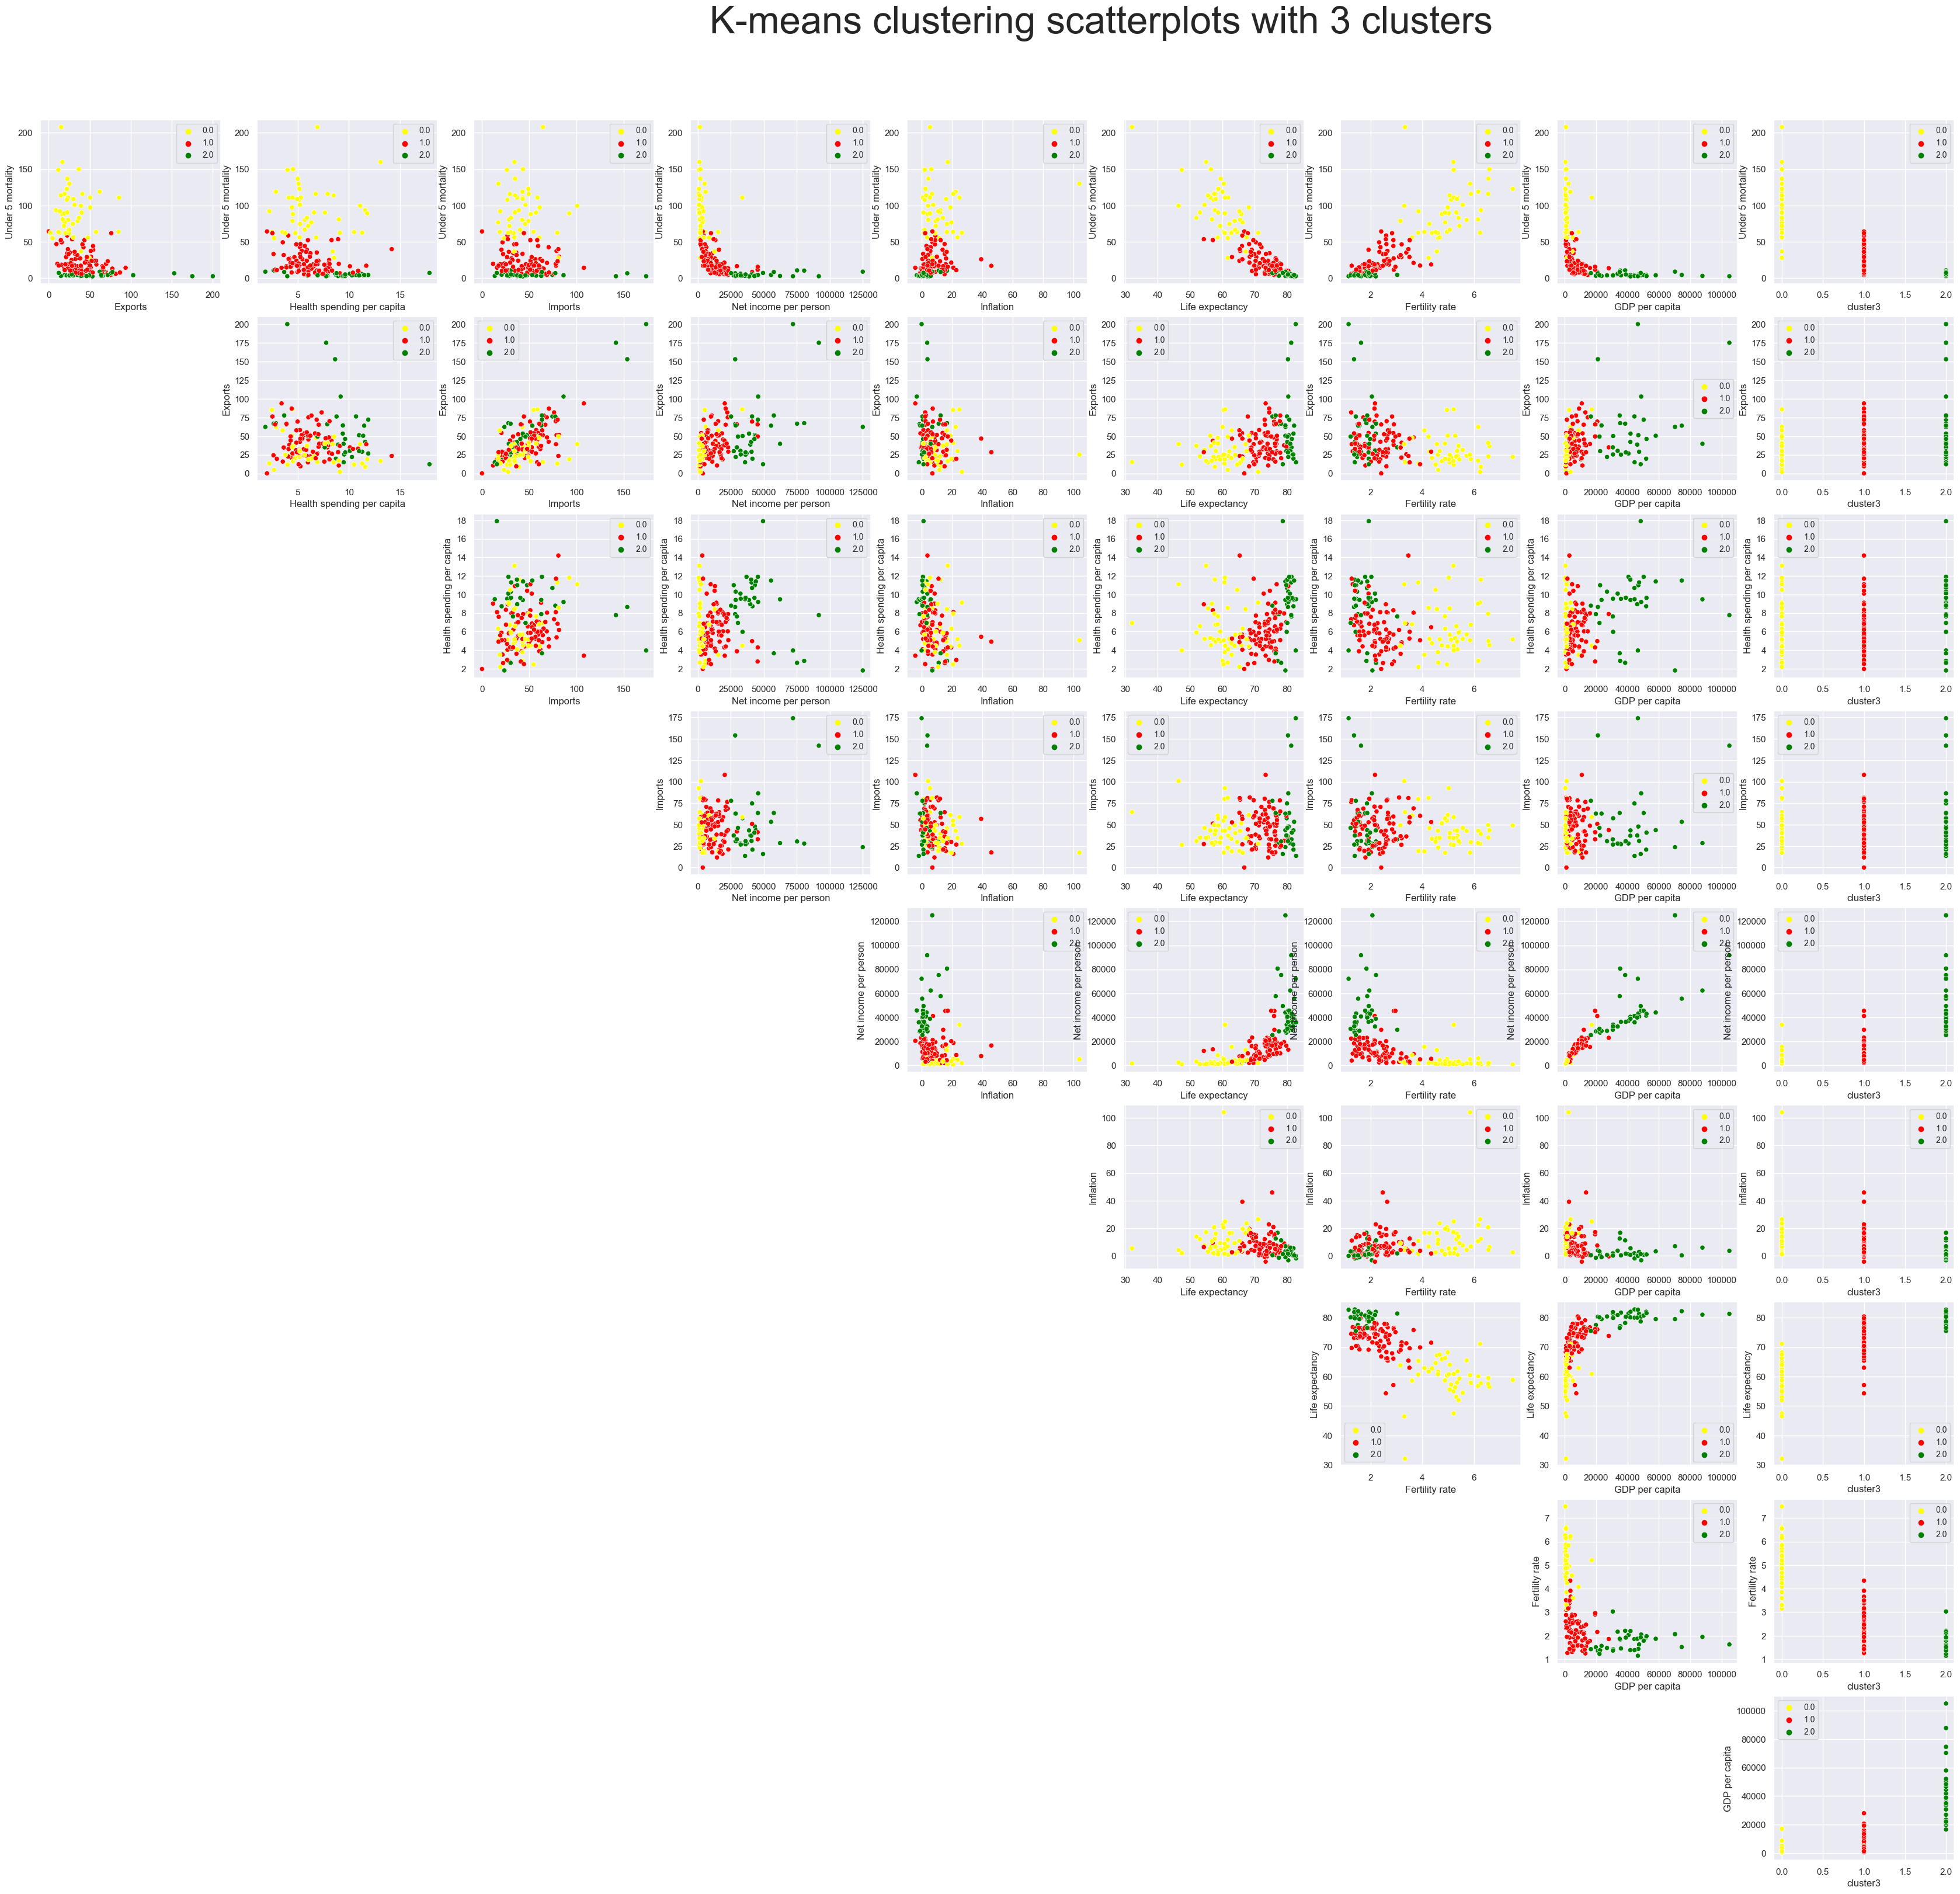

In [12]:
plt.figure(figsize = (71, 65))
plt.suptitle('K-means clustering scatterplots with 3 clusters',fontsize=47,y=0.91,x=0.433)
for j in range(len(df.iloc[1:].columns)-5):
    for i in range(len(df.iloc[1:].columns)-5):
        if i>j:
            plt.subplot(len(df.iloc[1:].columns),len(df.iloc[1:].columns),i+1+j*len(df.iloc[1:].columns))
            g=sns.scatterplot(x = df.iloc[:,i+1], y = df.iloc[:,j+1], data = df[1:], hue = 'cluster3', palette = ['yellow','red','green'])
            g.legend(fontsize=10)
plt.savefig('/Users/rebeccaharrison/Documents/Python/Bootcamp/Output/Graphs/unsupervised_scatter3clusters.png')
plt.show()
# the variables that don't show much correlation with the outcome are: exports, imports, health

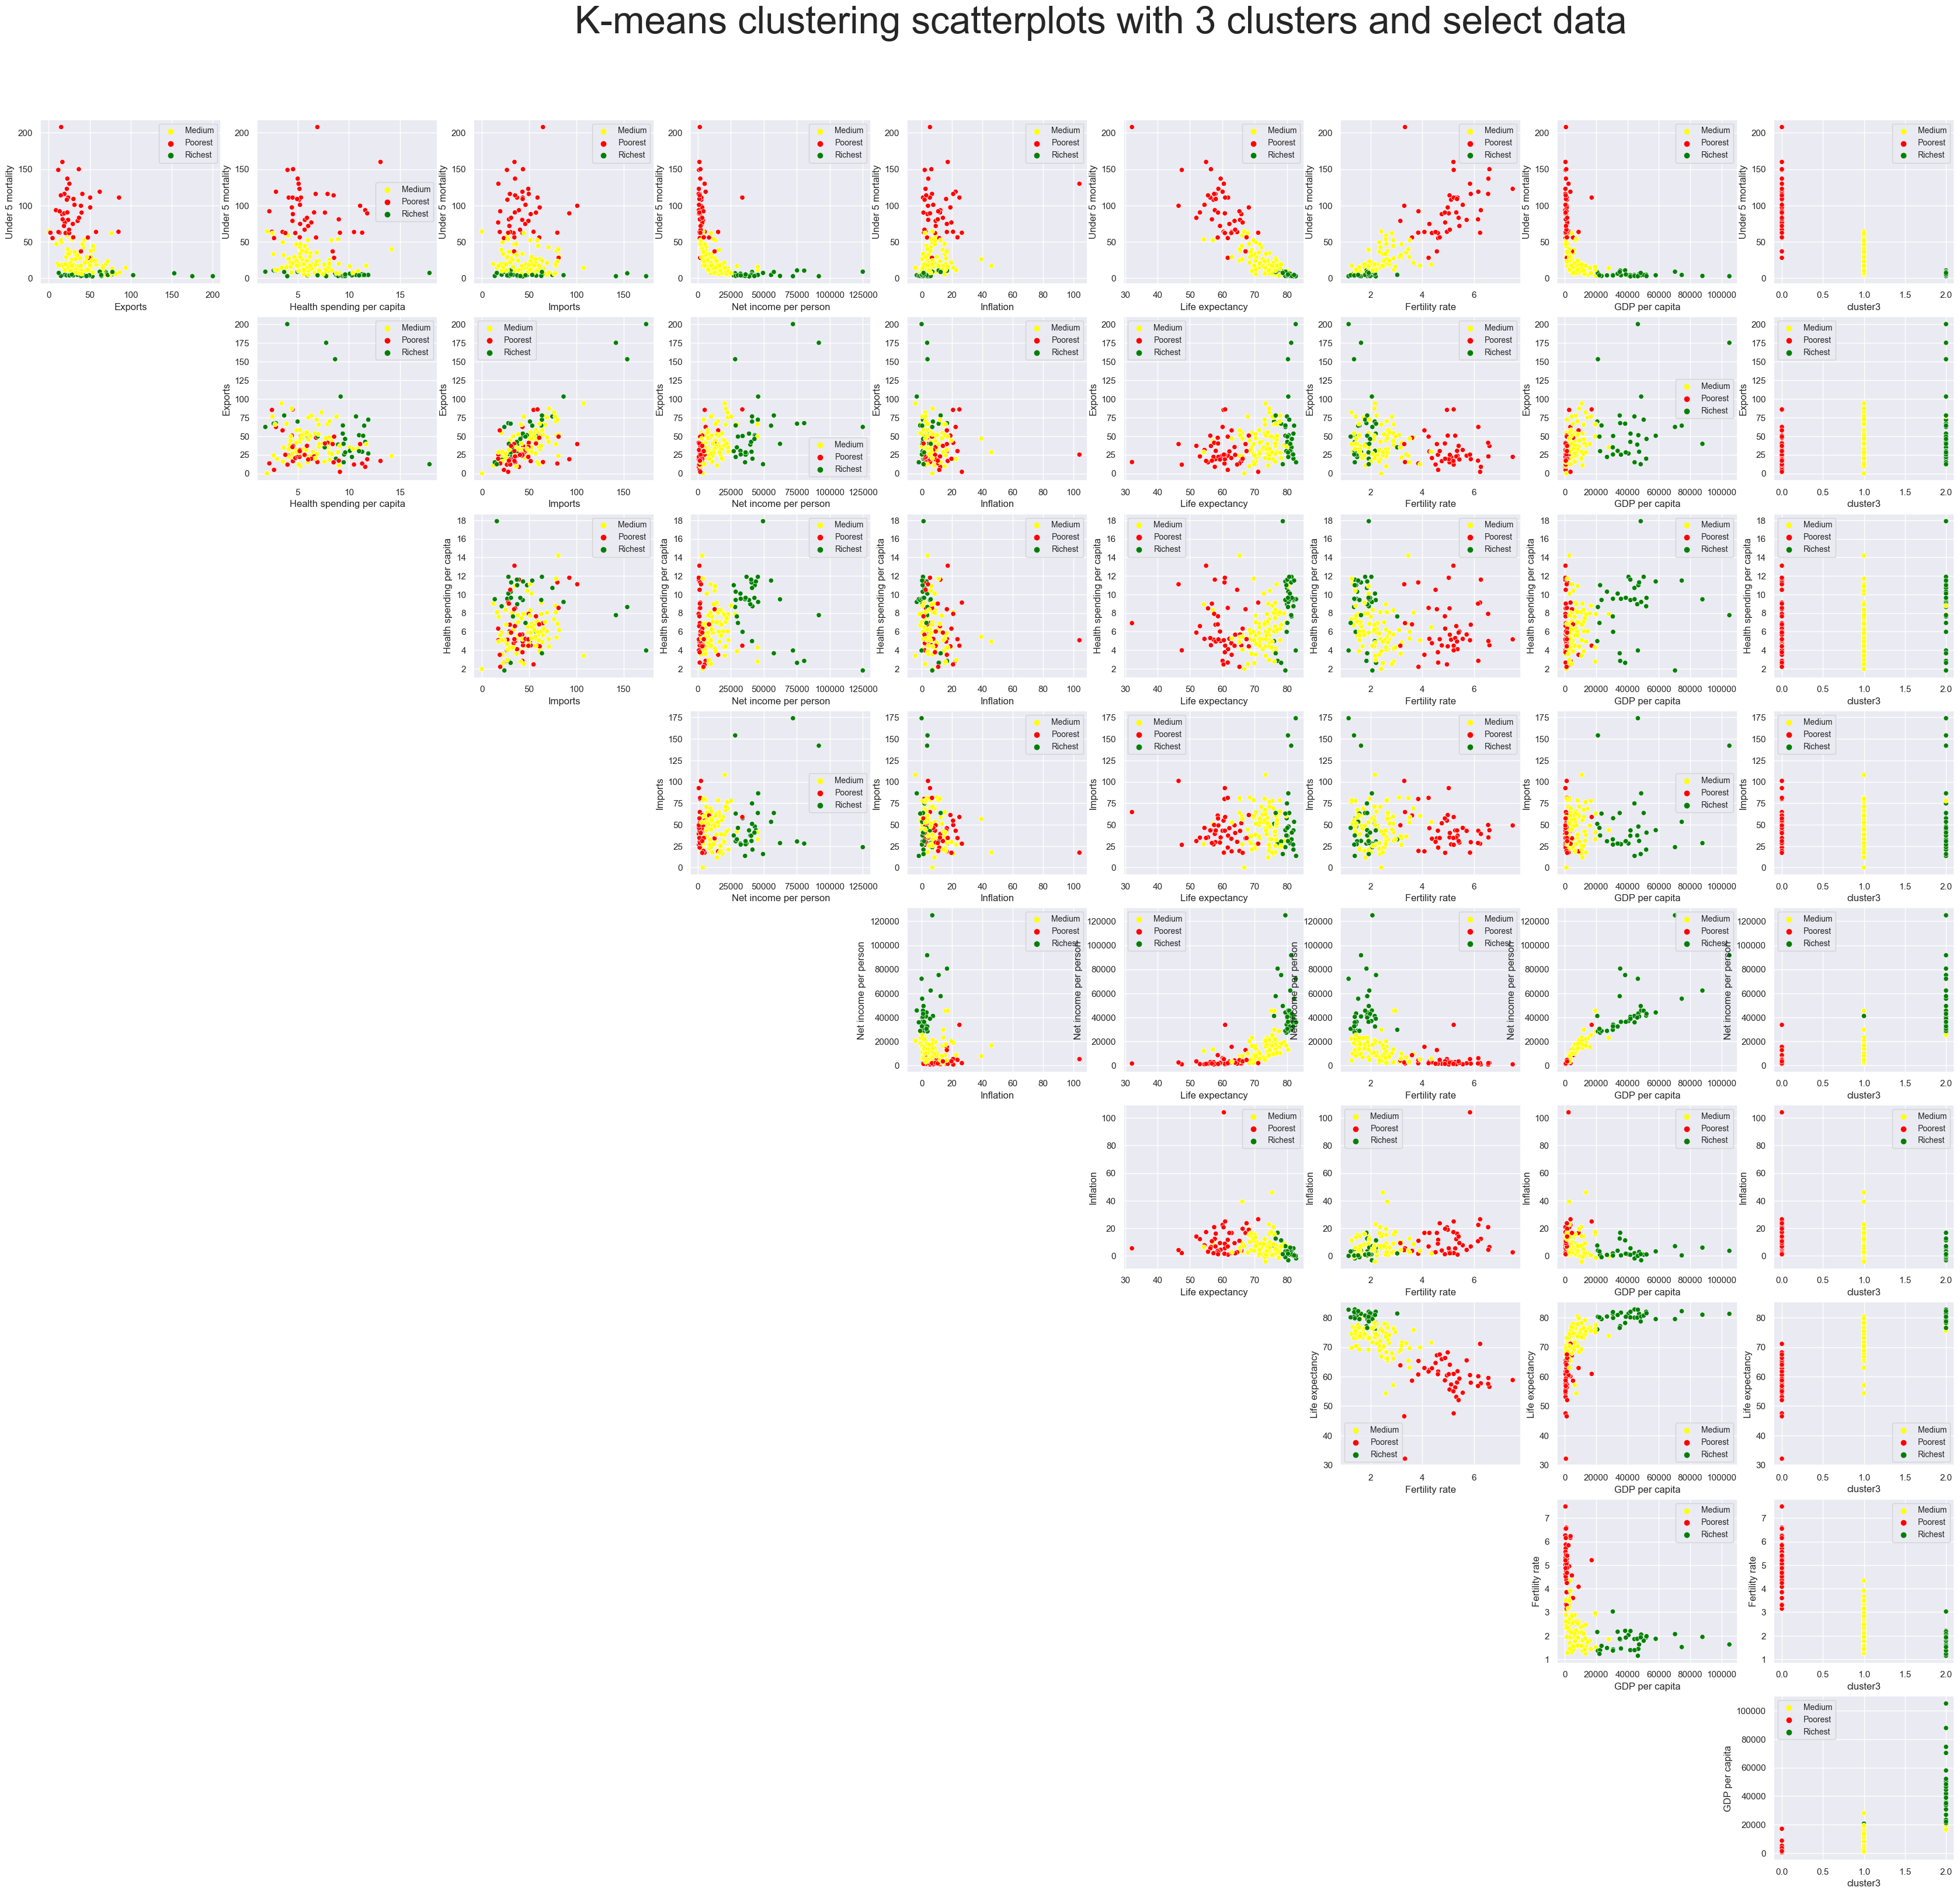

In [13]:
plt.figure(figsize = (71, 65))
plt.suptitle('K-means clustering scatterplots with 3 clusters and select data',fontsize=47,y=0.91,x=0.433)
for j in range(len(df.iloc[1:].columns)-5):
    for i in range(len(df.iloc[1:].columns)-5):
        if i>j:
            plt.subplot(len(df.iloc[1:].columns),len(df.iloc[1:].columns),i+1+j*len(df.iloc[1:].columns))
            g=sns.scatterplot(x = df.iloc[:,i+1], y = df.iloc[:,j+1], data = df[1:], hue = 'cluster3small', palette = ['yellow','red','green'])
            g.legend(fontsize=10)
            plt.savefig('/Users/rebeccaharrison/Documents/Python/Bootcamp/Output/Graphs/unsupervised_scatter3clustersselect.png')
plt.show()
# the variables that don't show much correlation with the outcome are: exports, imports, health so they have been removed from the model this time

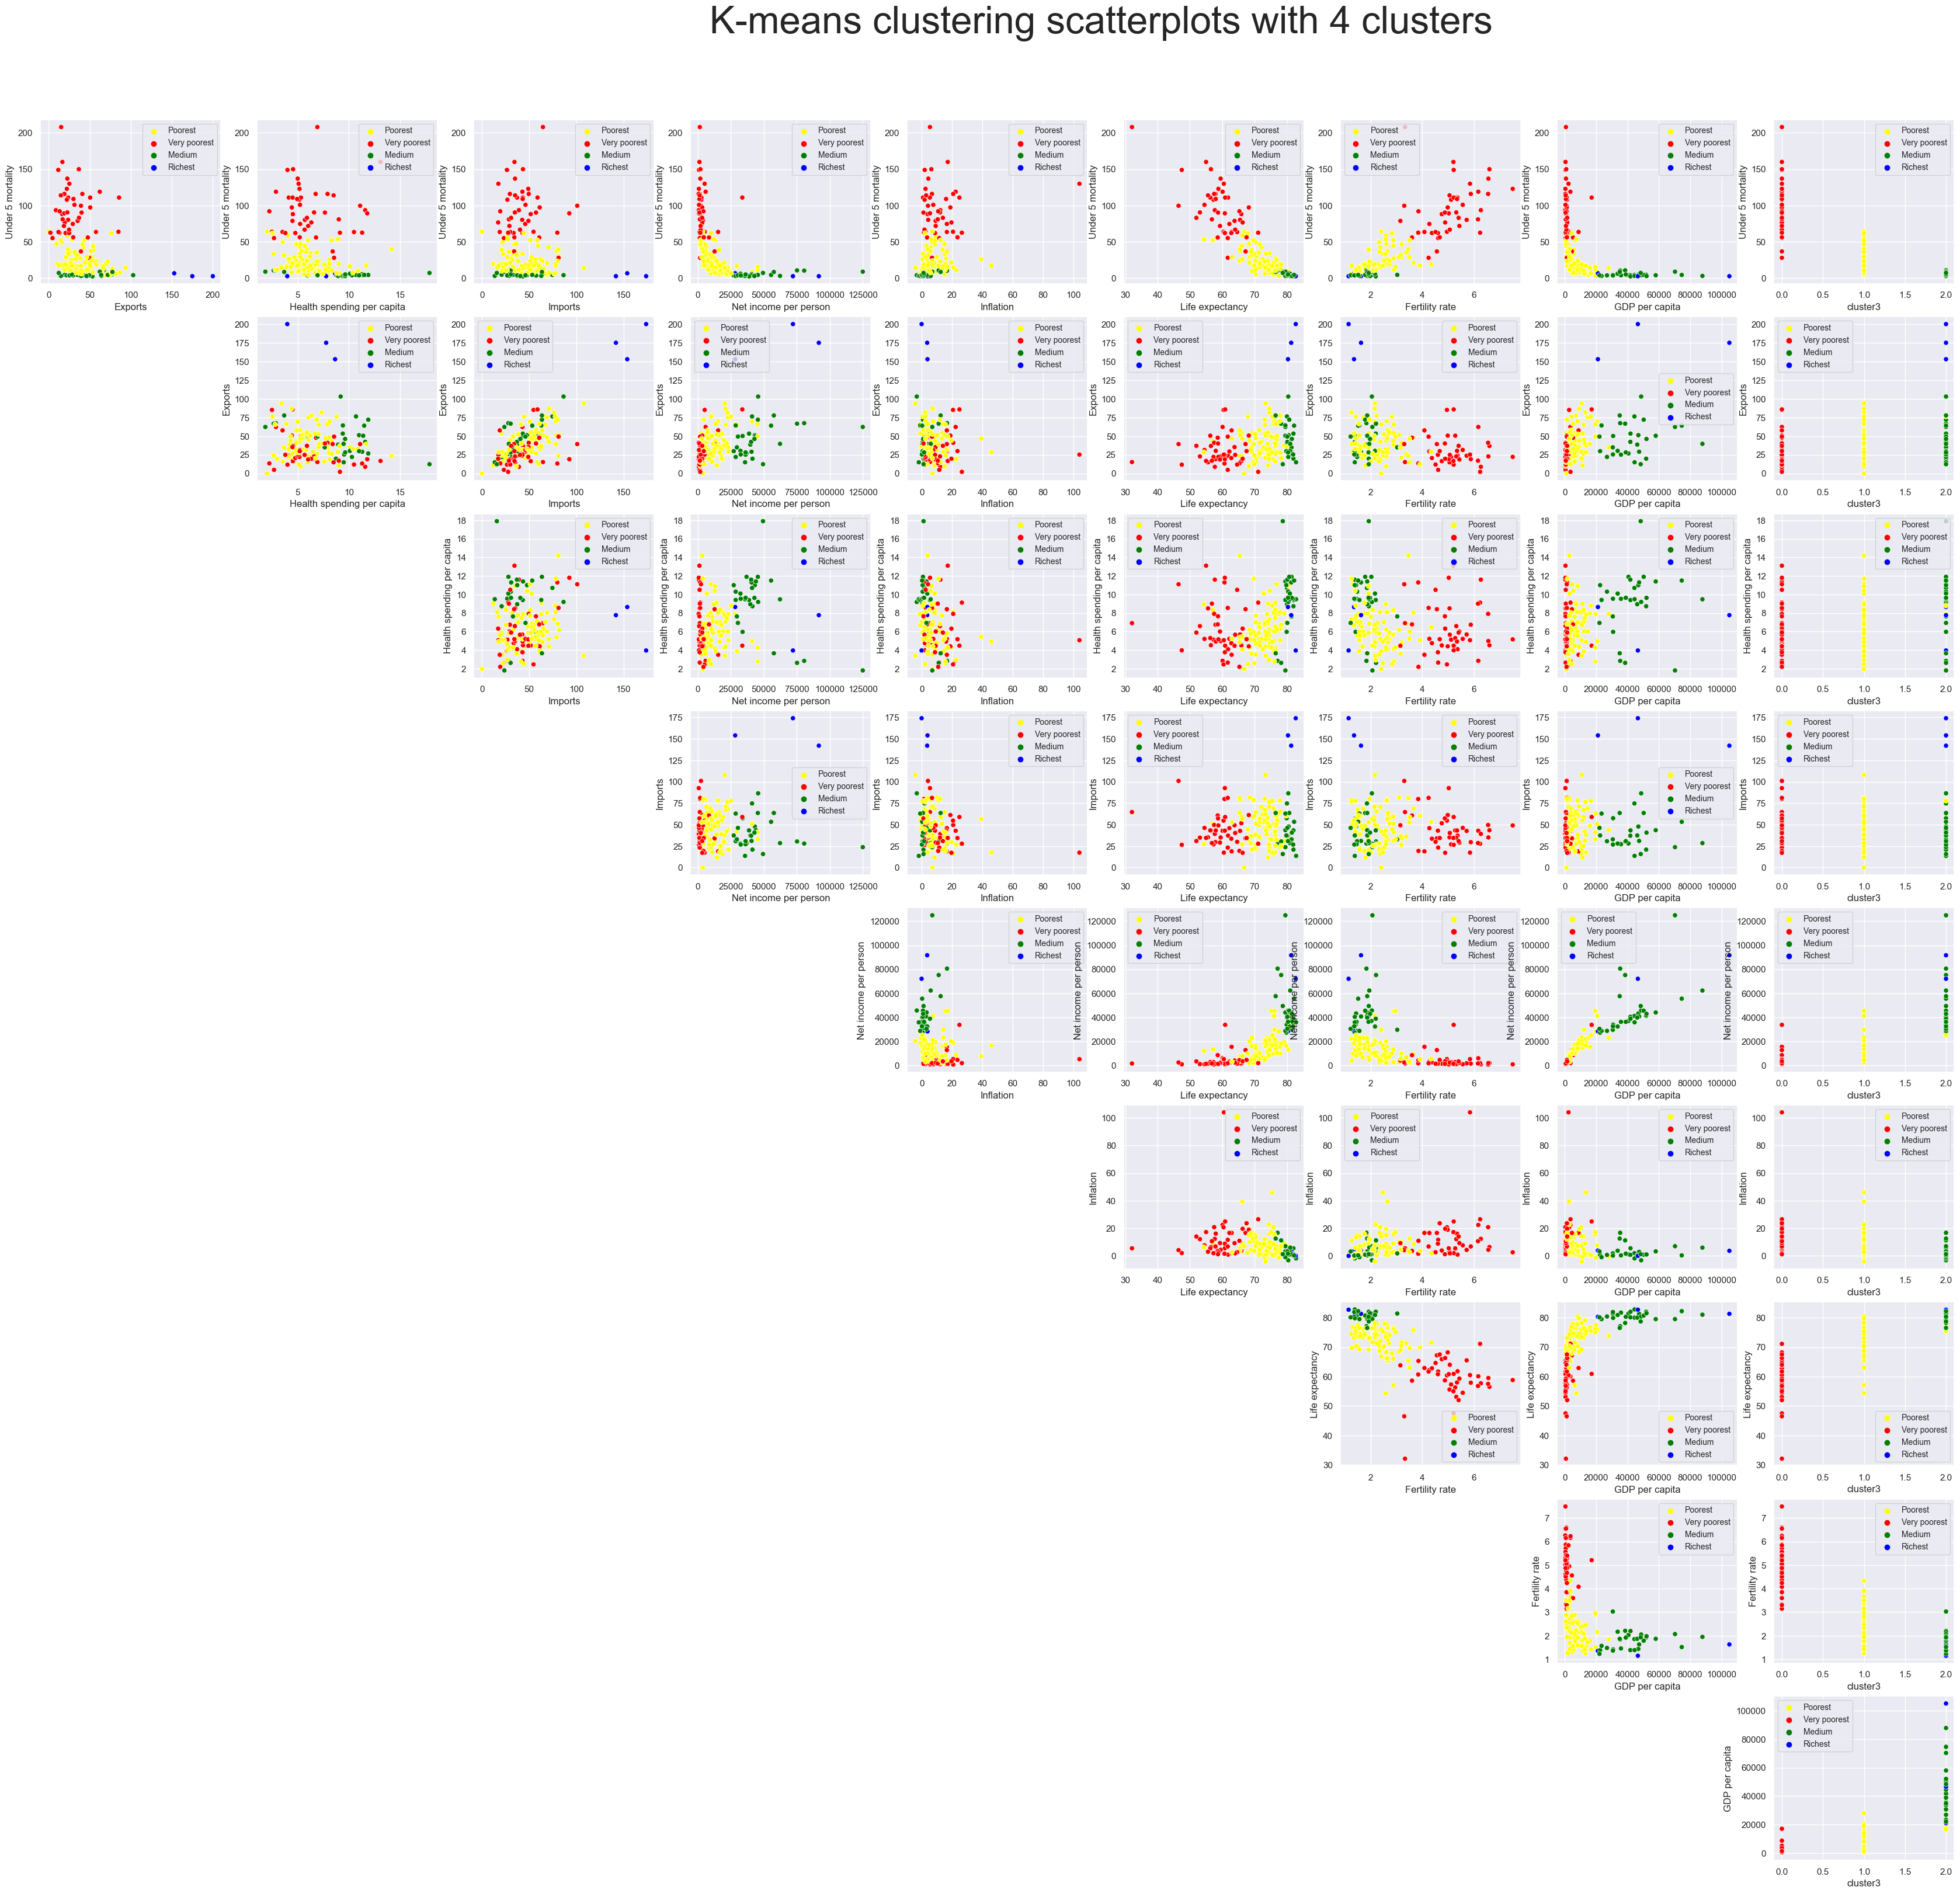

In [14]:
plt.figure(figsize = (71, 65))
plt.suptitle('K-means clustering scatterplots with 4 clusters',fontsize=47,y=0.91,x=0.433)
for j in range(len(df.iloc[1:].columns)-5):
    for i in range(len(df.iloc[1:].columns)-5):
        if i>j:
            plt.subplot(len(df.iloc[1:].columns),len(df.iloc[1:].columns),i+1+j*len(df.iloc[1:].columns))
            g=sns.scatterplot(x = df.iloc[:,i+1], y = df.iloc[:,j+1], data = df[1:], hue = 'cluster4', palette = ['yellow','red','green','blue'])
            g.legend(fontsize=10)
plt.savefig('/Users/rebeccaharrison/Documents/Python/Bootcamp/Output/Graphs/unsupervised_scatter4clusters.png')
plt.show()

# the 4th cluster doesn't add much, better to use 3

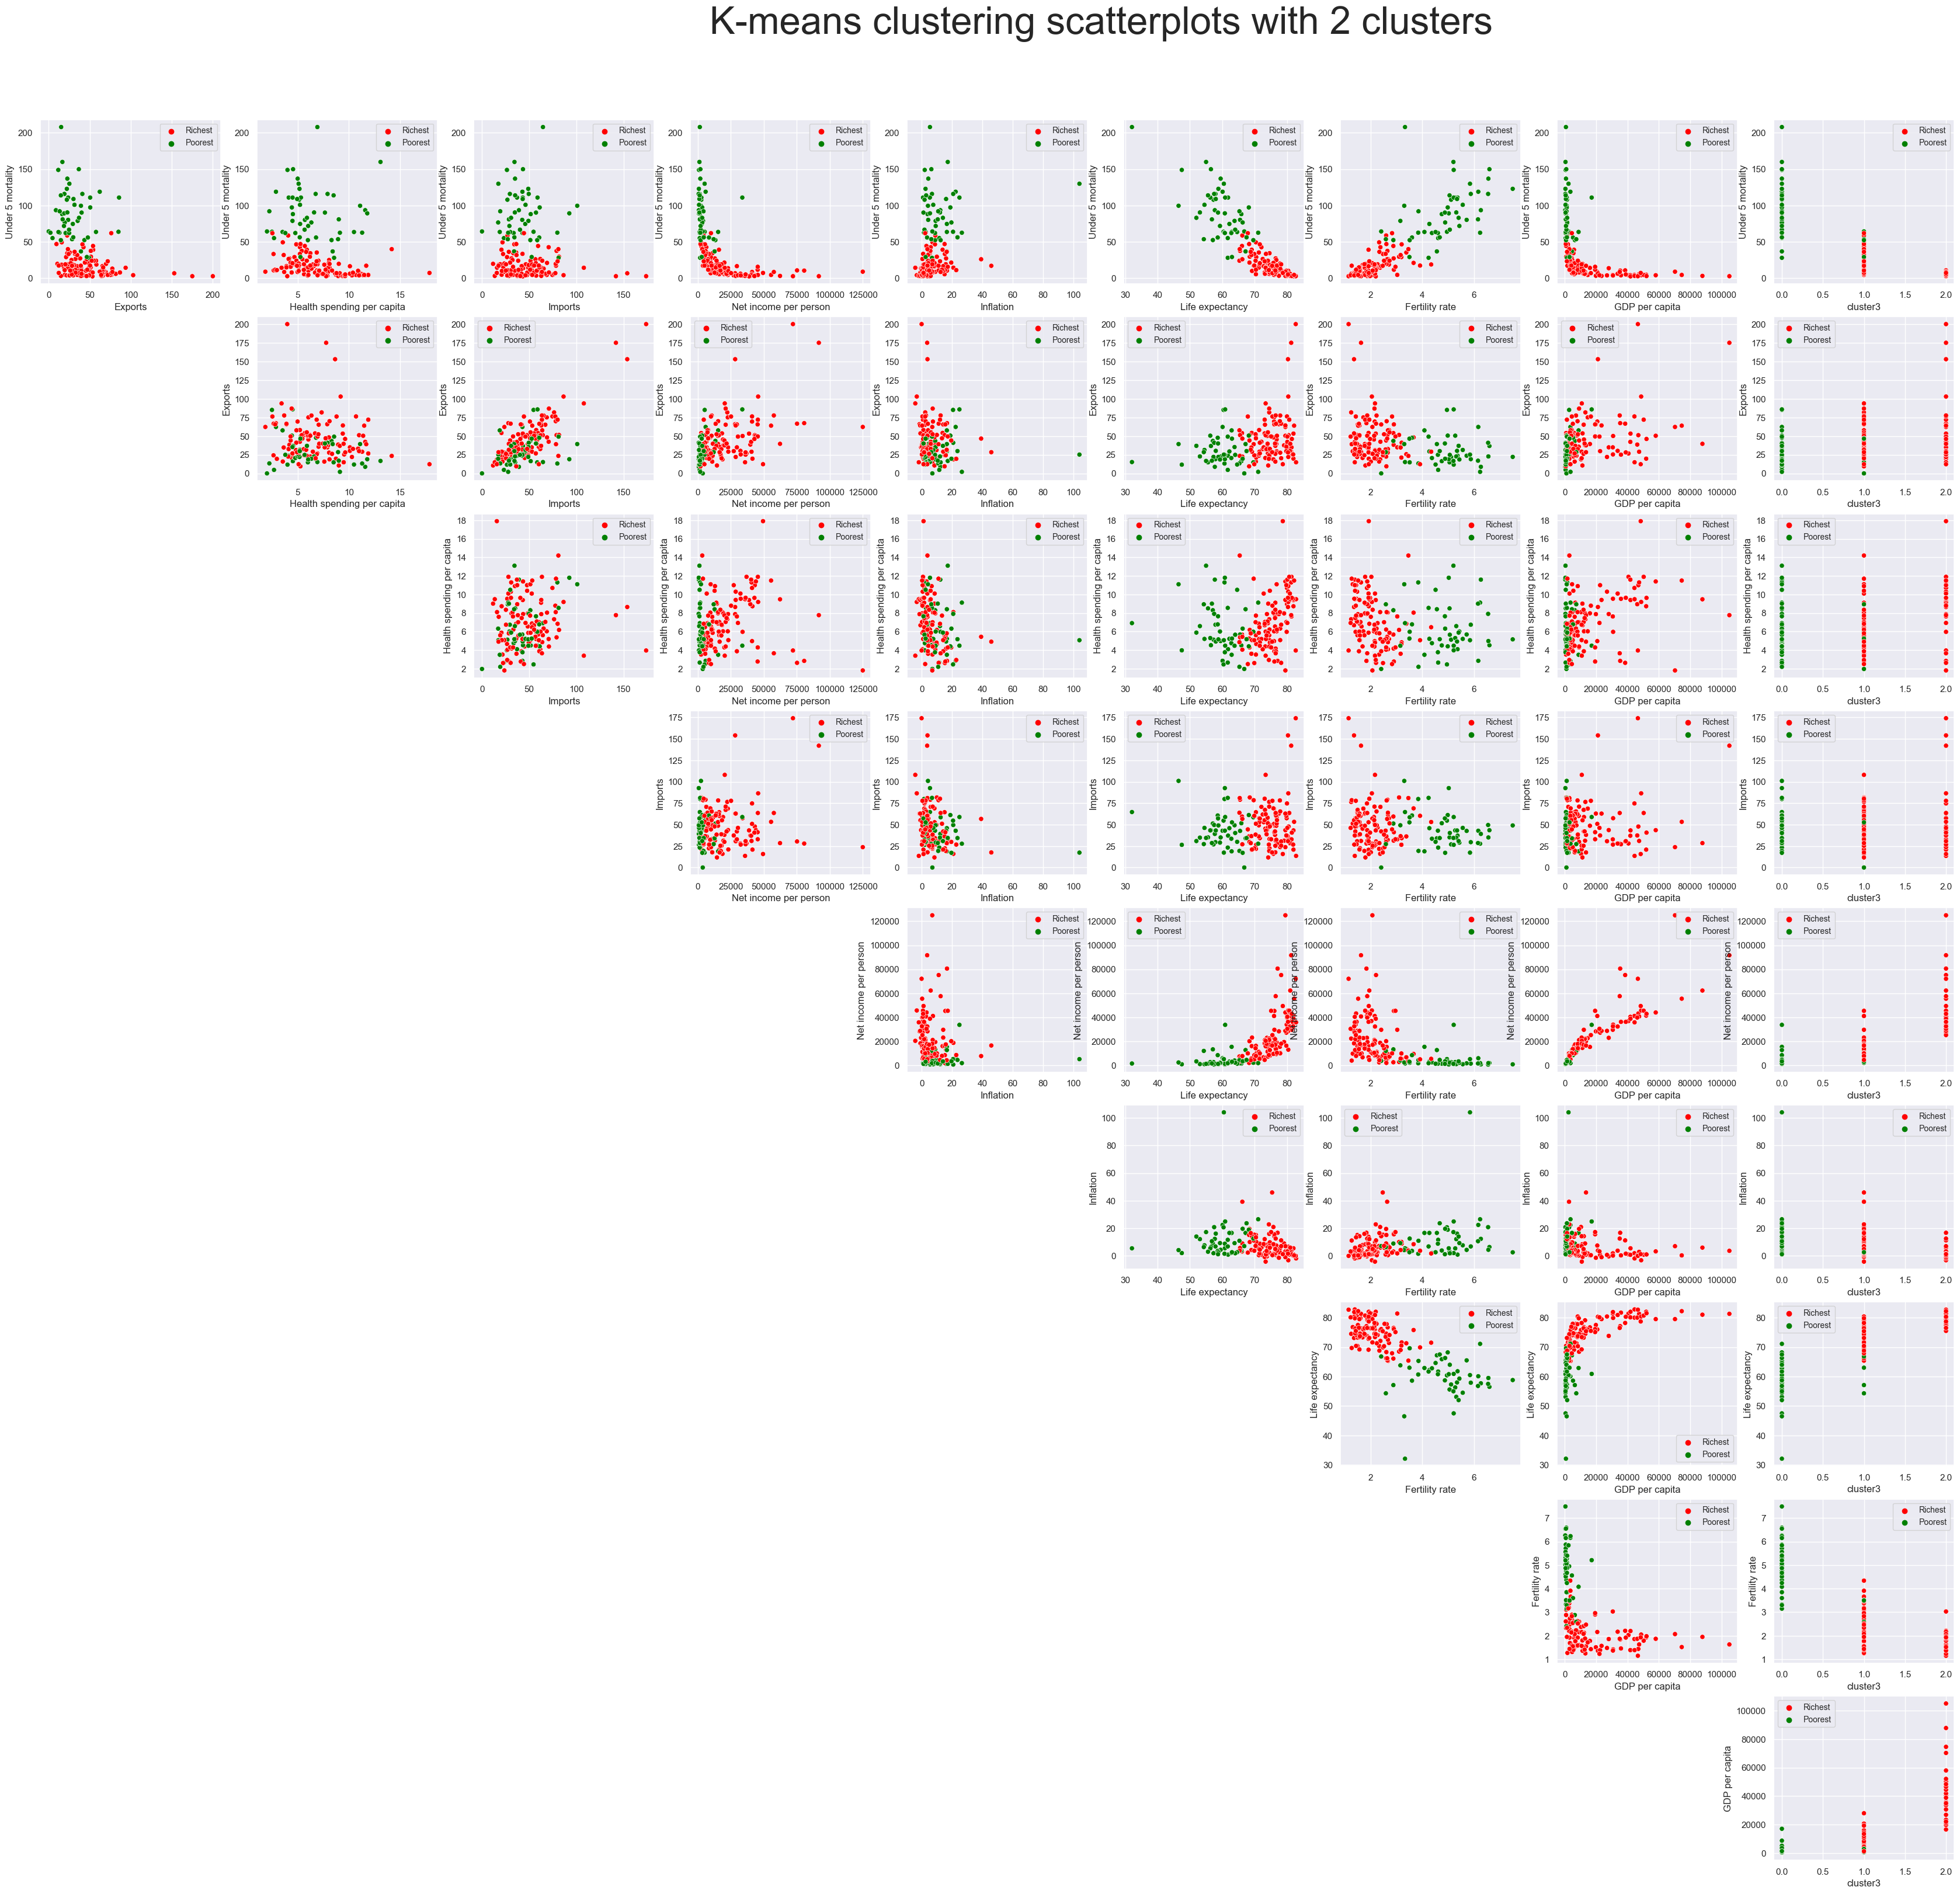

In [15]:
plt.figure(figsize = (71, 65))
plt.suptitle('K-means clustering scatterplots with 2 clusters',fontsize=47,y=0.91,x=0.433)
for j in range(len(df.iloc[1:].columns)-5):
    for i in range(len(df.iloc[1:].columns)-5):
        if i>j:
            plt.subplot(len(df.iloc[1:].columns),len(df.iloc[1:].columns),i+1+j*len(df.iloc[1:].columns))
            g=sns.scatterplot(x = df.iloc[:,i+1], y = df.iloc[:,j+1], data = df[1:], hue = 'cluster2', palette = ['red','green'])
            g.legend(fontsize=10)
plt.savefig('/Users/rebeccaharrison/Documents/Python/Bootcamp/Output/Graphs/unsupervised_scatter2clusters.png')
plt.show()

# the 4th cluster doesn't add much, better to use 3

In [16]:
fig = px.choropleth(df[['country','clusterfinal']],
                    locationmode='country names',
                    locations='country',
                    title='K means country based clustering (3 clusters)',
                    hover_name="country",
                    color_discrete_sequence=["orange", "red", "green",'black'],color=df['clusterfinal'], 
                    color_discrete_map={'Poorest':'Red',
                                        'Medium':'Yellow',
                                        'Richest':'Green'} )
fig.update_geos(fitbounds="locations", visible=True)

fig.update_layout(legend_title_text='Labels',legend_title_side='top',title_pad_l=260,title_y=0.86)

plt.tight_layout()
plt.savefig('/Users/rebeccaharrison/Documents/Python/Bootcamp/Output/Graphs/unsupervised_map3clusters.png')
fig.show(engine='kaleido')

<Figure size 640x480 with 0 Axes>

In [17]:
fig = px.choropleth(df[['country','cluster2']],
                    locationmode='country names',
                    locations='country',
                    title='K means country based clustering (2 clusters)',
                    hover_name="country",
                    color_discrete_sequence=["orange", "red", "green",'black'],color=df['cluster2'], 

                    color_discrete_map={'Poorest':'Red',
                                        'Richest':'Green'} )
fig.update_geos(fitbounds="locations", visible=True)

fig.update_layout(legend_title_text='Labels',legend_title_side='top',title_pad_l=260,title_y=0.86)

plt.savefig('/Users/rebeccaharrison/Documents/Python/Bootcamp/Output/Graphs/unsupervised_map2clusters.png')

fig.show(engine='kaleido')

<Figure size 640x480 with 0 Axes>

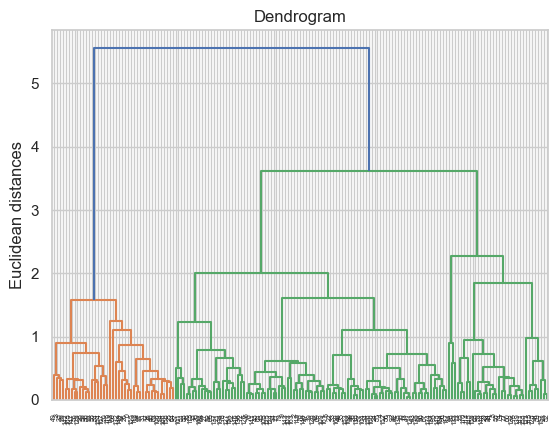

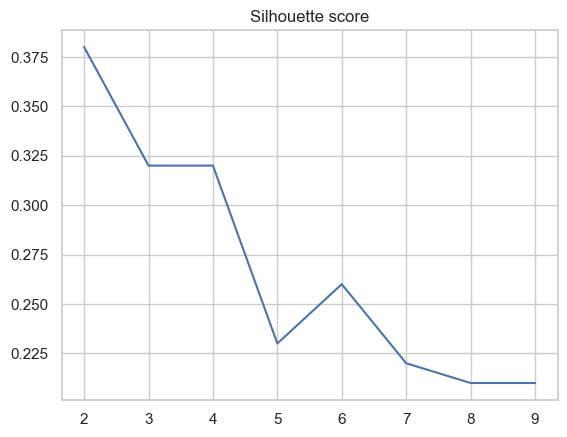

In [45]:
# Now trying with hierarchical clustering

# dendogram to show the groupings
dendrogram = sch.dendrogram(sch.linkage(df_scaled, method = 'ward'))
plt.title('Dendrogram')
plt.ylabel('Euclidean distances')
plt.savefig('/Users/rebeccaharrison/Documents/Python/Bootcamp/Output/Graphs/unsupervised_dendrogram.png')
plt.show()

# silhoute to estimate the number of cluster
score=[]
for i in range(2,10):
    hc=AgglomerativeClustering(i)
    hc.fit(df_scaled)
    score.append(np.round(silhouette_score(df_scaled,hc.labels_),2))
plt.plot(range(2,10),score)
plt.title('Silhouette score')
plt.savefig('/Users/rebeccaharrison/Documents/Python/Bootcamp/Output/Graphs/unsupervised_hierclusters.png')
plt.show()

# this suggests 2 again

In [19]:
hierarchical = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage = 'ward')
hiercluster2 = hierarchical.fit_predict(df_scaled)

# just trying 3 for comparison
hierarchical3 = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage = 'ward')
hiercluster3 = hierarchical3.fit_predict(df_scaled)

df['hiercluster2']=hiercluster2
df['hiercluster3']=hiercluster3


df['hiercluster3'].loc[df['hiercluster3'] == 0 ]= 'Richest'
df['hiercluster3'].loc[df['hiercluster3'] == 1 ]= 'Poorest'
df['hiercluster3'].loc[df['hiercluster3'] == 2 ]='Medium'

df['hiercluster2'].loc[df['hiercluster2'] == 0 ]= 'Richest'
df['hiercluster2'].loc[df['hiercluster2'] == 1 ]='Poorest'

# trying on the small dataset for comparison
hiercluster3small = hierarchical3.fit_predict(df_small)

df['hiercluster3small']=hiercluster3small

df['hiercluster3small'].loc[df['hiercluster3small'] == 0 ]= 'Medium'
df['hiercluster3small'].loc[df['hiercluster3small'] == 1 ]= 'Poorest'
df['hiercluster3small'].loc[df['hiercluster3small'] == 2 ]='Richest'
df

/var/folders/w3/j_v3f_rs4hlbh_rnzsc6j2rm0000gn/T/ipykernel_95489/1129648701.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/w3/j_v3f_rs4hlbh_rnzsc6j2rm0000gn/T/ipykernel_95489/1129648701.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/w3/j_v3f_rs4hlbh_rnzsc6j2rm0000gn/T/ipykernel_95489/1129648701.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



country  Under 5 mortality  Exports  \
0            Afghanistan               90.2     10.0   
1                Albania               16.6     28.0   
2                Algeria               27.3     38.4   
3                 Angola              119.0     62.3   
4    Antigua and Barbuda               10.3     45.5   
..                   ...                ...      ...   
162              Vanuatu               29.2     46.6   
163            Venezuela               17.1     28.5   
164              Vietnam               23.3     72.0   
165                Yemen               56.3     30.0   
166               Zambia               83.1     37.0   

     Health spending per capita  Imports  Net income per person  Inflation  \
0                          7.58     44.9                   1610       9.44   
1                          6.55     48.6                   9930       4.49   
2                          4.17     31.4                  12900      16.10   
3                          2.85     42.9                   5900      22.40   
4                          6.03     58.9                  19100       1.44   
..                          ...      ...                    ...        ...   
162                        5.25     52.7                   2950       2.62   
163                        4.91     17.6                  16500      45.90   
164                        6.84     80.2                   4490      12.10   
165                        5.18     34.4                   4480      23.60   
166                        5.89     30.9                   3280      14.00   

     Life expectancy  Fertility rate  GDP per capita  cluster3      cluster4  \
0               56.2            5.82             553         0  Very poorest   
1               76.3            1.65            4090         1       Poorest   
2               76.5            2.89            4460         1       Poorest   
3               60.1            6.16            3530         0  Very poorest   
4               76.8            2.13           12200         1       Poorest   
..               ...             ...             ...       ...           ...   
162             63.0            3.50            2970         1       Poorest   
163             75.4            2.47           13500         1       Poorest   
164             73.1            1.95            1310         1       Poorest   
165             67.5            4.67            1310         0  Very poorest   
166             52.0            5.40            1460         0  Very poorest   

    cluster2 clusterfinal cluster3small hiercluster2 hiercluster3  \
0    Poorest      Poorest       Poorest      Poorest      Poorest   
1    Richest       Medium        Medium      Richest       Medium   
2    Richest       Medium        Medium      Richest       Medium   
3    Poorest      Poorest       Poorest      Poorest      Poorest   
4    Richest       Medium        Medium      Richest       Medium   
..       ...          ...           ...          ...          ...   
162  Poorest       Medium        Medium      Richest       Medium   
163  Richest       Medium        Medium      Richest       Medium   
164  Richest       Medium        Medium      Richest       Medium   
165  Poorest      Poorest       Poorest      Poorest      Poorest   
166  Poorest      Poorest       Poorest      Poorest      Poorest   

    hiercluster3small  
0             Poorest  
1              Medium  
2              Medium  
3             Poorest  
4              Medium  
..                ...  
162            Medium  
163            Medium  
164            Medium  
165           Poorest  
166           Poorest  

[167 rows x 18 columns]

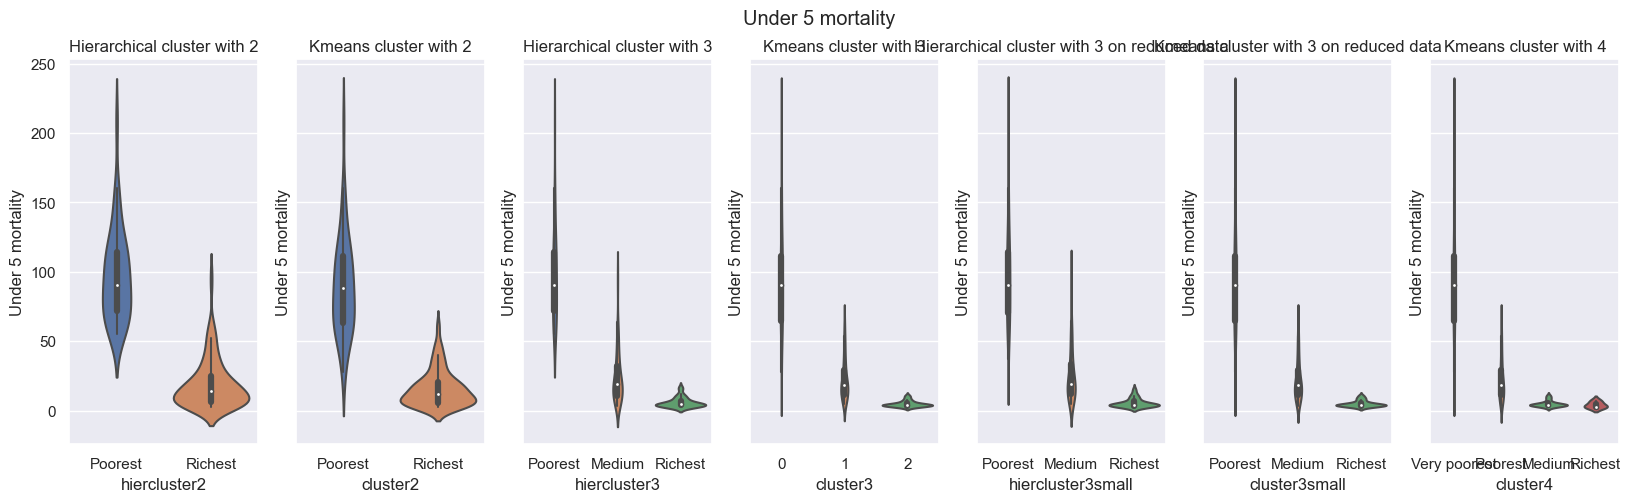

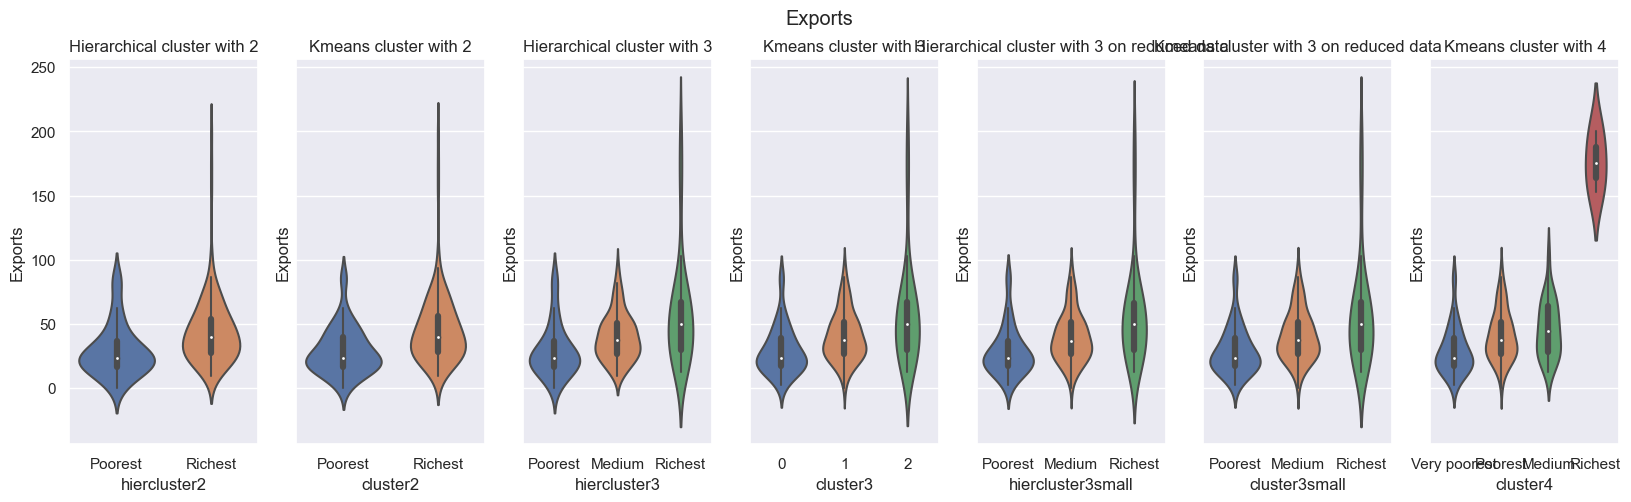

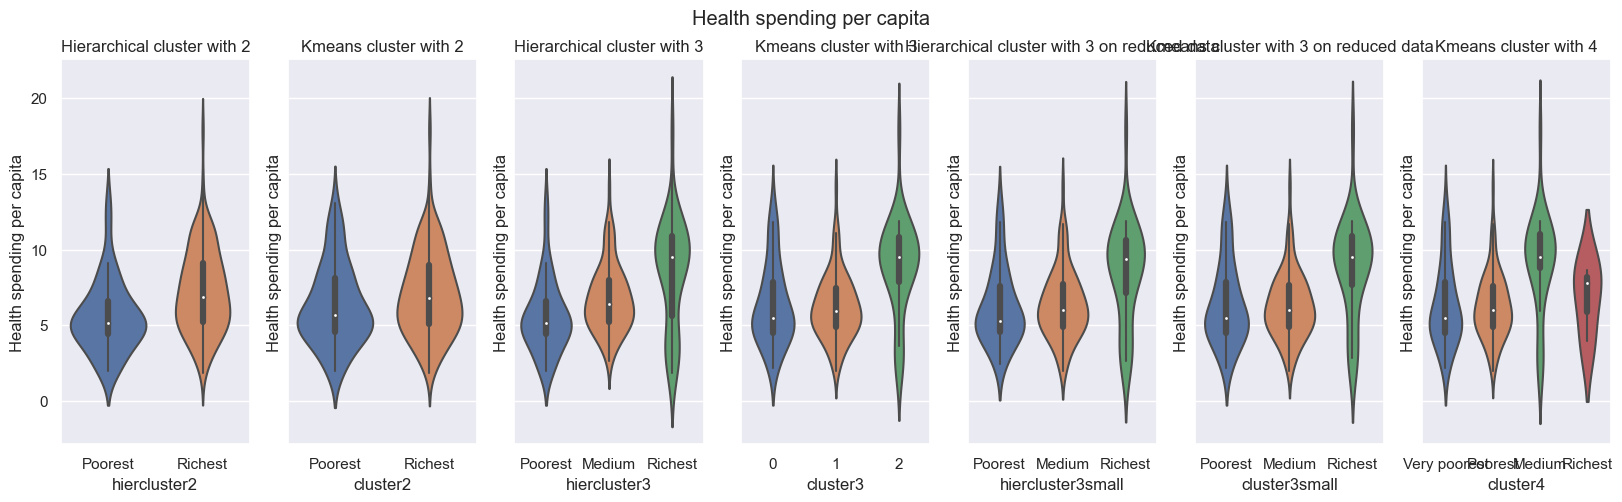

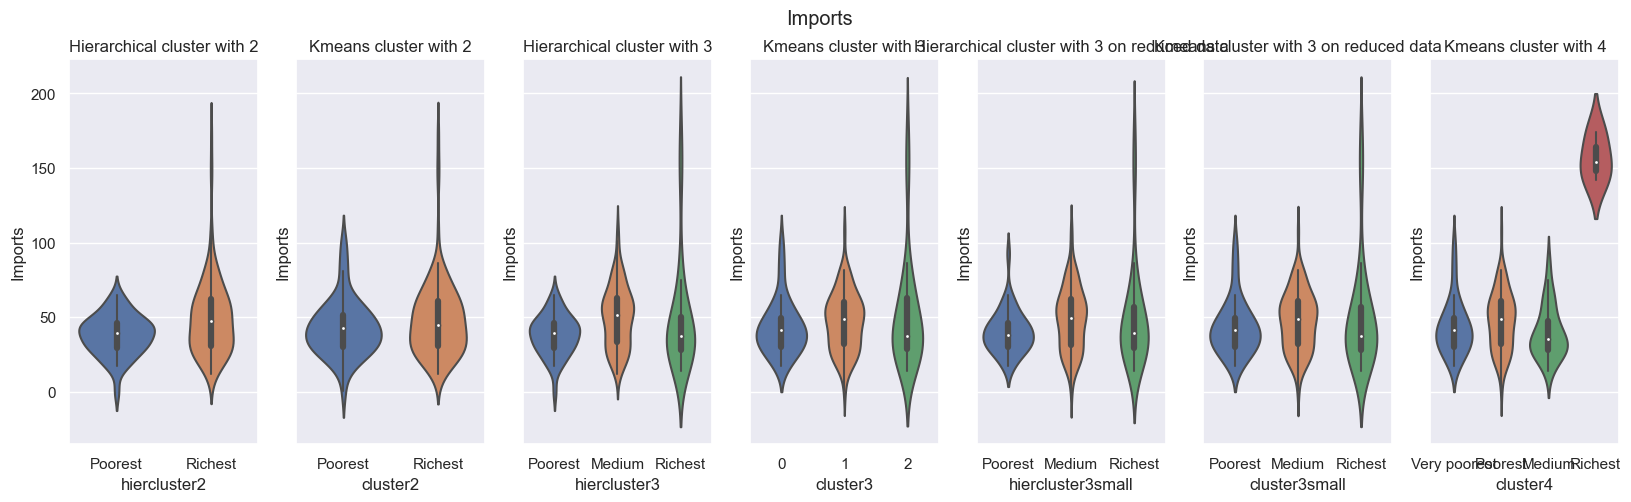

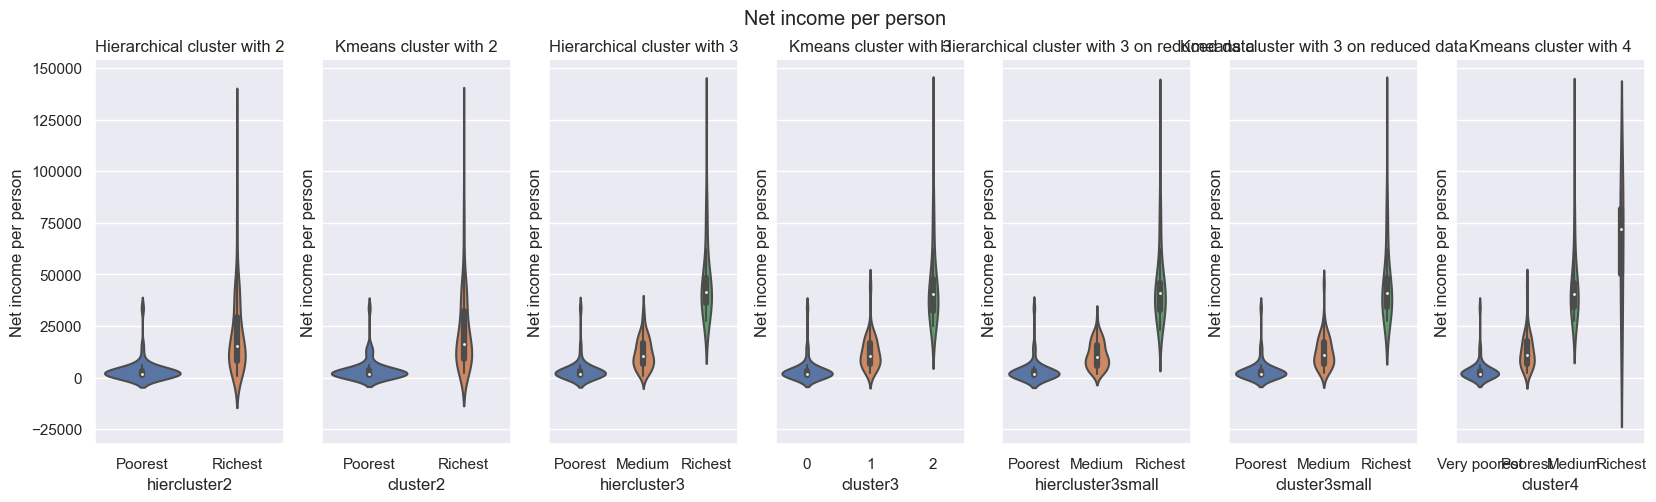

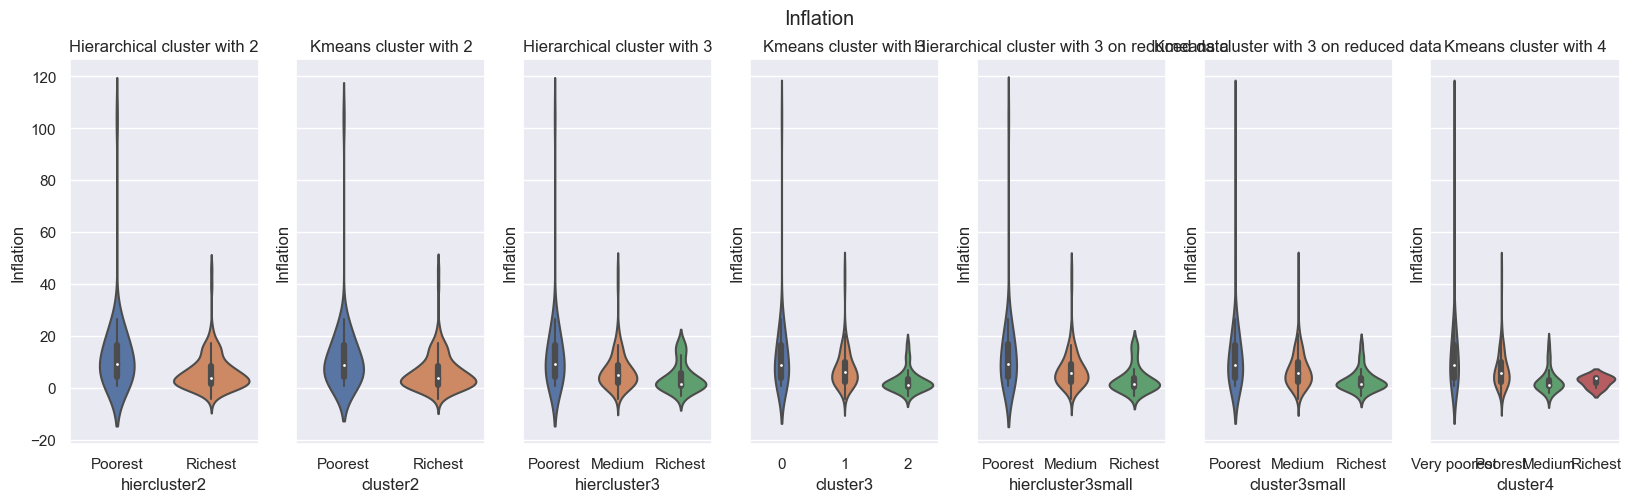

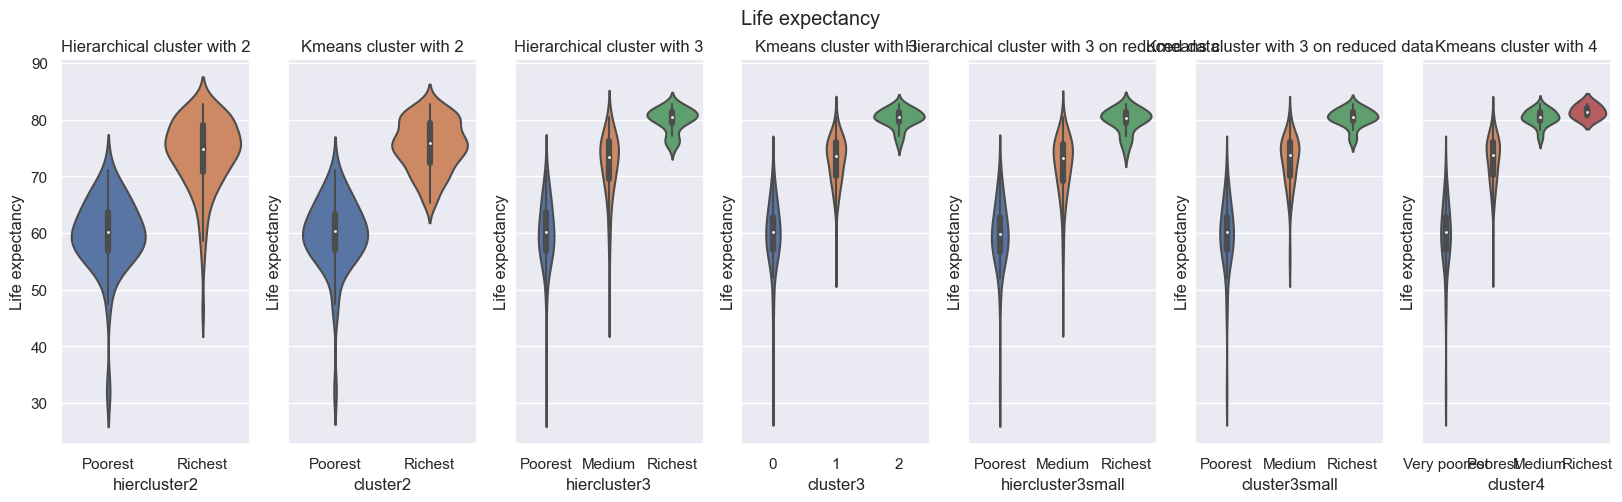

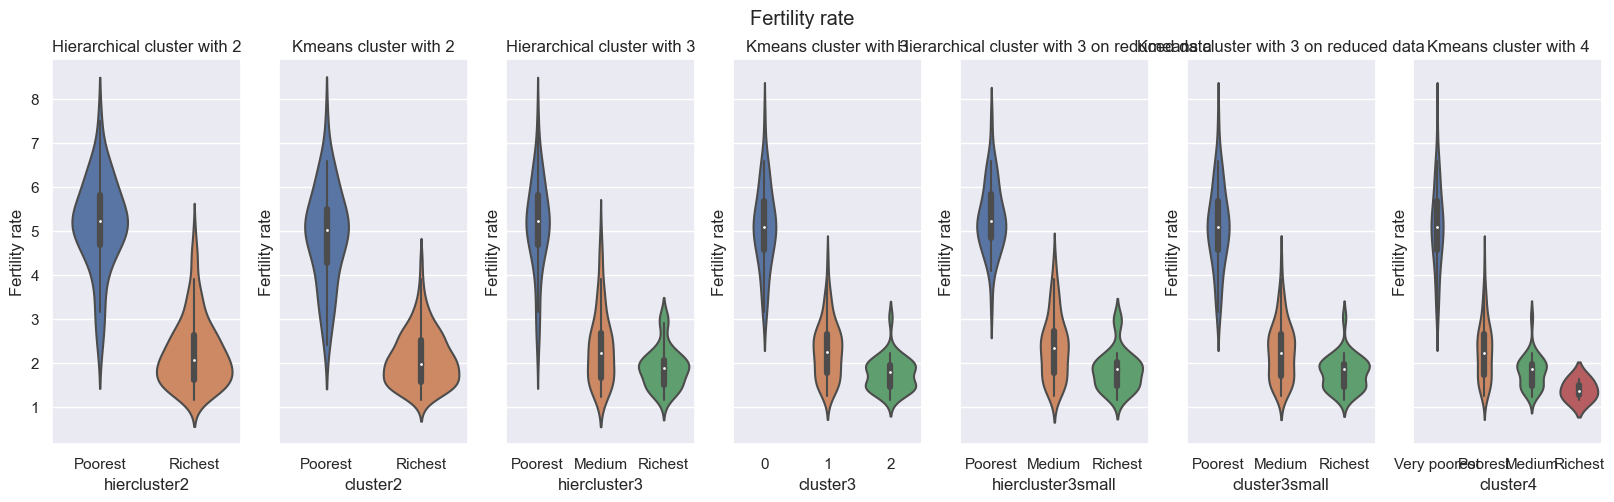

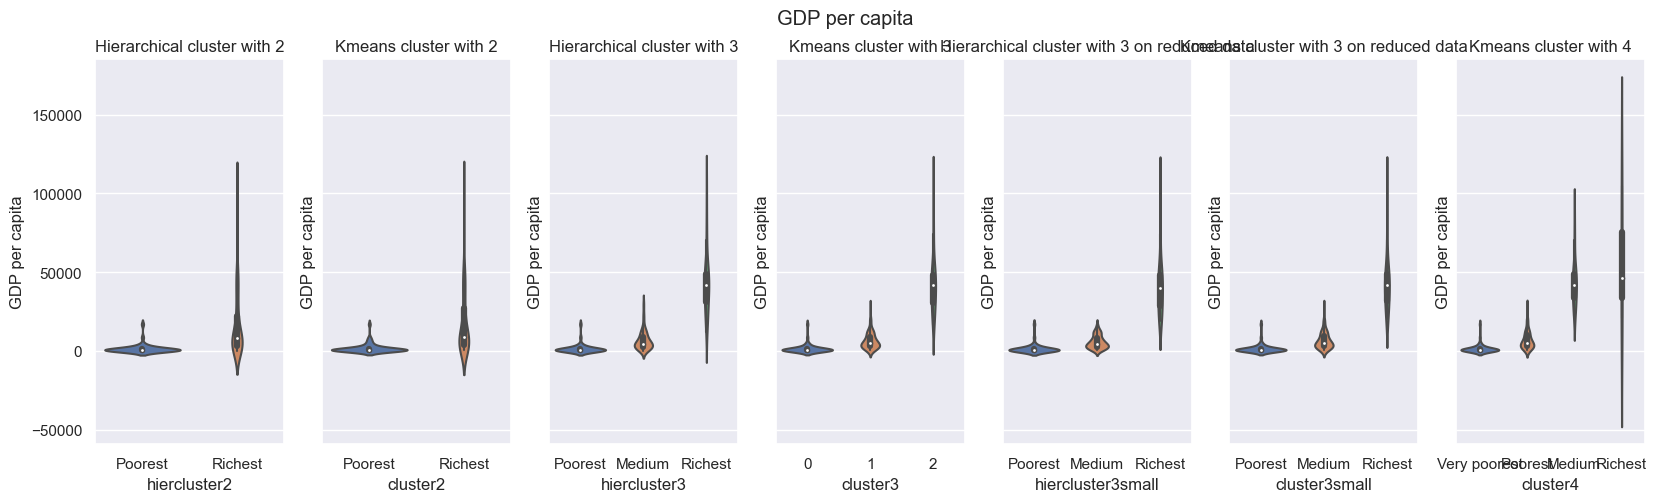

In [20]:

for variable in list(df.iloc[:,1:10].columns):
    fig, axes = plt.subplots(1, 7, sharey=True, figsize=(20,5))
    fig.suptitle(variable)
    axes[0].set_title('Hierarchical cluster with 2')

    sns.violinplot(ax=axes[0], data=df, y=variable, x="hiercluster2",orient="v")
    axes[0].set_title('Hierarchical cluster with 2')
    sns.violinplot(ax=axes[1], data=df, y=variable, x="cluster2",orient="v")
    axes[1].set_title('Kmeans cluster with 2')
    sns.violinplot(ax=axes[2], data=df, y=variable, x="hiercluster3",orient="v")
    axes[2].set_title('Hierarchical cluster with 3')
    sns.violinplot(ax=axes[3], data=df, y=variable, x="cluster3",orient="v")
    axes[3].set_title('Kmeans cluster with 3')
    sns.violinplot(ax=axes[4], data=df, y=variable, x="hiercluster3small",orient="v")
    axes[4].set_title('Hierarchical cluster with 3 on reduced data')
    sns.violinplot(ax=axes[5], data=df, y=variable, x="cluster3small",orient="v")
    axes[5].set_title('Kmeans cluster with 3 on reduced data')
    sns.violinplot(ax=axes[6], data=df, y=variable, x="cluster4",orient="v")
    axes[6].set_title('Kmeans cluster with 4')




In [21]:
# inspecting the differences between outputs
df[df['cluster2']!=df['hiercluster2']]

country  Under 5 mortality  Exports  Health spending per capita  \
21          Botswana               52.5     43.6                        8.30   
72              Iraq               36.9     39.4                        8.41   
81          Kiribati               62.7     13.3                       11.30   
87           Lesotho               99.7     39.4                       11.10   
88           Liberia               89.3     19.1                       11.80   
108          Namibia               56.0     47.8                        6.78   
126           Rwanda               63.6     12.0                       10.50   
136  Solomon Islands               28.1     49.3                        8.55   
137     South Africa               53.7     28.6                        8.94   
146       Tajikistan               52.4     14.9                        5.98   
154     Turkmenistan               62.0     76.3                        2.50   
162          Vanuatu               29.2     46.6                        5.25   

     Imports  Net income per person  Inflation  Life expectancy  \
21      51.3                  13300       8.92             57.1   
72      34.1                  12700      16.60             67.2   
81      79.9                   1730       1.52             60.7   
87     101.0                   2380       4.15             46.5   
88      92.6                    700       5.47             60.8   
108     60.7                   8460       3.56             58.6   
126     30.0                   1350       2.61             64.6   
136     81.2                   1780       6.81             61.7   
137     27.4                  12000       6.35             54.3   
146     58.6                   2110      12.50             69.6   
154     44.5                   9940       2.31             67.9   
162     52.7                   2950       2.62             63.0   

     Fertility rate  GDP per capita  cluster3      cluster4 cluster2  \
21             2.88            6350         1       Poorest  Poorest   
72             4.56            4500         0  Very poorest  Poorest   
81             3.84            1490         0  Very poorest  Poorest   
87             3.30            1170         0  Very poorest  Poorest   
88             5.02             327         0  Very poorest  Poorest   
108            3.60            5190         0  Very poorest  Poorest   
126            4.51             563         0  Very poorest  Poorest   
136            4.24            1290         0  Very poorest  Poorest   
137            2.59            7280         1       Poorest  Poorest   
146            3.51             738         1       Poorest  Poorest   
154            2.83            4440         1       Poorest  Richest   
162            3.50            2970         1       Poorest  Poorest   

    clusterfinal cluster3small hiercluster2 hiercluster3 hiercluster3small  
21        Medium        Medium      Richest       Medium            Medium  
72       Poorest       Poorest      Richest       Medium           Poorest  
81       Poorest       Poorest      Richest       Medium            Medium  
87       Poorest       Poorest      Richest       Medium            Medium  
88       Poorest       Poorest      Richest       Medium           Poorest  
108      Poorest       Poorest      Richest       Medium            Medium  
126      Poorest       Poorest      Richest       Medium           Poorest  
136      Poorest       Poorest      Richest       Medium            Medium  
137       Medium        Medium      Richest       Medium            Medium  
146       Medium        Medium      Richest       Medium            Medium  
154       Medium        Medium      Poorest      Poorest            Medium  
162       Medium        Medium      Richest       Medium            Medium

In [22]:
# inspecting the differences between outputs
df[df['cluster3']!=df['cluster3small']]
# Very little differnece here

country  Under 5 mortality  Exports  \
0            Afghanistan               90.2     10.0   
1                Albania               16.6     28.0   
2                Algeria               27.3     38.4   
3                 Angola              119.0     62.3   
4    Antigua and Barbuda               10.3     45.5   
..                   ...                ...      ...   
162              Vanuatu               29.2     46.6   
163            Venezuela               17.1     28.5   
164              Vietnam               23.3     72.0   
165                Yemen               56.3     30.0   
166               Zambia               83.1     37.0   

     Health spending per capita  Imports  Net income per person  Inflation  \
0                          7.58     44.9                   1610       9.44   
1                          6.55     48.6                   9930       4.49   
2                          4.17     31.4                  12900      16.10   
3                          2.85     42.9                   5900      22.40   
4                          6.03     58.9                  19100       1.44   
..                          ...      ...                    ...        ...   
162                        5.25     52.7                   2950       2.62   
163                        4.91     17.6                  16500      45.90   
164                        6.84     80.2                   4490      12.10   
165                        5.18     34.4                   4480      23.60   
166                        5.89     30.9                   3280      14.00   

     Life expectancy  Fertility rate  GDP per capita  cluster3      cluster4  \
0               56.2            5.82             553         0  Very poorest   
1               76.3            1.65            4090         1       Poorest   
2               76.5            2.89            4460         1       Poorest   
3               60.1            6.16            3530         0  Very poorest   
4               76.8            2.13           12200         1       Poorest   
..               ...             ...             ...       ...           ...   
162             63.0            3.50            2970         1       Poorest   
163             75.4            2.47           13500         1       Poorest   
164             73.1            1.95            1310         1       Poorest   
165             67.5            4.67            1310         0  Very poorest   
166             52.0            5.40            1460         0  Very poorest   

    cluster2 clusterfinal cluster3small hiercluster2 hiercluster3  \
0    Poorest      Poorest       Poorest      Poorest      Poorest   
1    Richest       Medium        Medium      Richest       Medium   
2    Richest       Medium        Medium      Richest       Medium   
3    Poorest      Poorest       Poorest      Poorest      Poorest   
4    Richest       Medium        Medium      Richest       Medium   
..       ...          ...           ...          ...          ...   
162  Poorest       Medium        Medium      Richest       Medium   
163  Richest       Medium        Medium      Richest       Medium   
164  Richest       Medium        Medium      Richest       Medium   
165  Poorest      Poorest       Poorest      Poorest      Poorest   
166  Poorest      Poorest       Poorest      Poorest      Poorest   

    hiercluster3small  
0             Poorest  
1              Medium  
2              Medium  
3             Poorest  
4              Medium  
..                ...  
162            Medium  
163            Medium  
164            Medium  
165           Poorest  
166           Poorest  

[167 rows x 18 columns]

In [23]:
# inspecting the differences between outputs
df[df['cluster3']!=df['hiercluster3']]

country  Under 5 mortality  Exports  \
0            Afghanistan               90.2     10.0   
1                Albania               16.6     28.0   
2                Algeria               27.3     38.4   
3                 Angola              119.0     62.3   
4    Antigua and Barbuda               10.3     45.5   
..                   ...                ...      ...   
162              Vanuatu               29.2     46.6   
163            Venezuela               17.1     28.5   
164              Vietnam               23.3     72.0   
165                Yemen               56.3     30.0   
166               Zambia               83.1     37.0   

     Health spending per capita  Imports  Net income per person  Inflation  \
0                          7.58     44.9                   1610       9.44   
1                          6.55     48.6                   9930       4.49   
2                          4.17     31.4                  12900      16.10   
3                          2.85     42.9                   5900      22.40   
4                          6.03     58.9                  19100       1.44   
..                          ...      ...                    ...        ...   
162                        5.25     52.7                   2950       2.62   
163                        4.91     17.6                  16500      45.90   
164                        6.84     80.2                   4490      12.10   
165                        5.18     34.4                   4480      23.60   
166                        5.89     30.9                   3280      14.00   

     Life expectancy  Fertility rate  GDP per capita  cluster3      cluster4  \
0               56.2            5.82             553         0  Very poorest   
1               76.3            1.65            4090         1       Poorest   
2               76.5            2.89            4460         1       Poorest   
3               60.1            6.16            3530         0  Very poorest   
4               76.8            2.13           12200         1       Poorest   
..               ...             ...             ...       ...           ...   
162             63.0            3.50            2970         1       Poorest   
163             75.4            2.47           13500         1       Poorest   
164             73.1            1.95            1310         1       Poorest   
165             67.5            4.67            1310         0  Very poorest   
166             52.0            5.40            1460         0  Very poorest   

    cluster2 clusterfinal cluster3small hiercluster2 hiercluster3  \
0    Poorest      Poorest       Poorest      Poorest      Poorest   
1    Richest       Medium        Medium      Richest       Medium   
2    Richest       Medium        Medium      Richest       Medium   
3    Poorest      Poorest       Poorest      Poorest      Poorest   
4    Richest       Medium        Medium      Richest       Medium   
..       ...          ...           ...          ...          ...   
162  Poorest       Medium        Medium      Richest       Medium   
163  Richest       Medium        Medium      Richest       Medium   
164  Richest       Medium        Medium      Richest       Medium   
165  Poorest      Poorest       Poorest      Poorest      Poorest   
166  Poorest      Poorest       Poorest      Poorest      Poorest   

    hiercluster3small  
0             Poorest  
1              Medium  
2              Medium  
3             Poorest  
4              Medium  
..                ...  
162            Medium  
163            Medium  
164            Medium  
165           Poorest  
166           Poorest  

[167 rows x 18 columns]

In [24]:
# Who are in this cluster 4
df[df['cluster4']=="Richest" ]


country  Under 5 mortality  Exports  Health spending per capita  \
91   Luxembourg                2.8    175.0                        7.77   
98        Malta                6.8    153.0                        8.65   
133   Singapore                2.8    200.0                        3.96   

     Imports  Net income per person  Inflation  Life expectancy  \
91     142.0                  91700      3.620             81.3   
98     154.0                  28300      3.830             80.3   
133    174.0                  72100     -0.046             82.7   

     Fertility rate  GDP per capita  cluster3 cluster4 cluster2 clusterfinal  \
91             1.63          105000         2  Richest  Richest      Richest   
98             1.36           21100         2  Richest  Richest      Richest   
133            1.15           46600         2  Richest  Richest      Richest   

    cluster3small hiercluster2 hiercluster3 hiercluster3small  
91        Richest      Richest      Richest           Richest  
98        Richest      Richest      Richest           Richest  
133       Richest      Richest      Richest           Richest

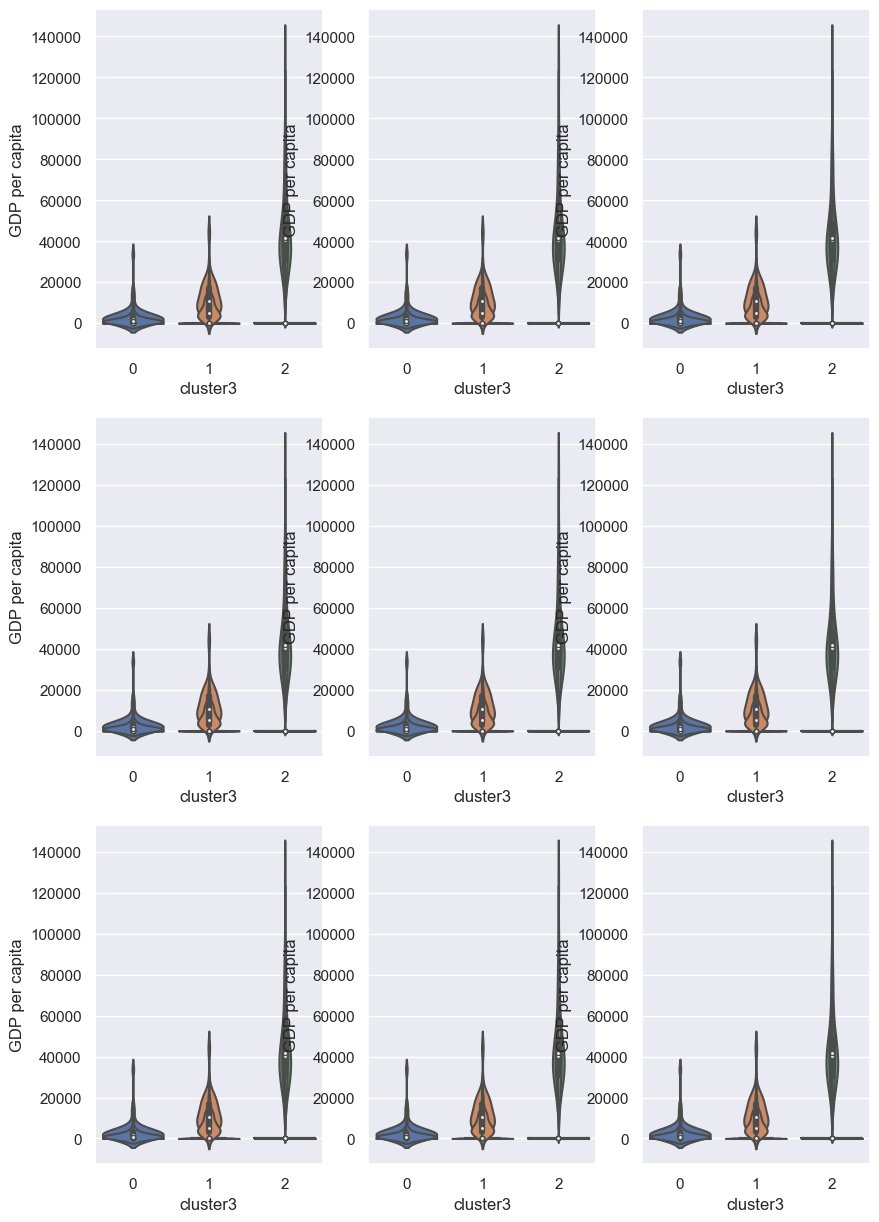

In [25]:
sns.set()
fig, axes = plt.subplots(3, 3, figsize=[10, 15])
variables = list(df.iloc[:,1:10].columns)
for var in variables:
    for row in (0,1,2):
        for col in (0,1,2):
            
            sns.violinplot(x='cluster3', y=var, data=df, ax=axes[row, col])

plt.show()




/var/folders/w3/j_v3f_rs4hlbh_rnzsc6j2rm0000gn/T/ipykernel_95489/1531883602.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



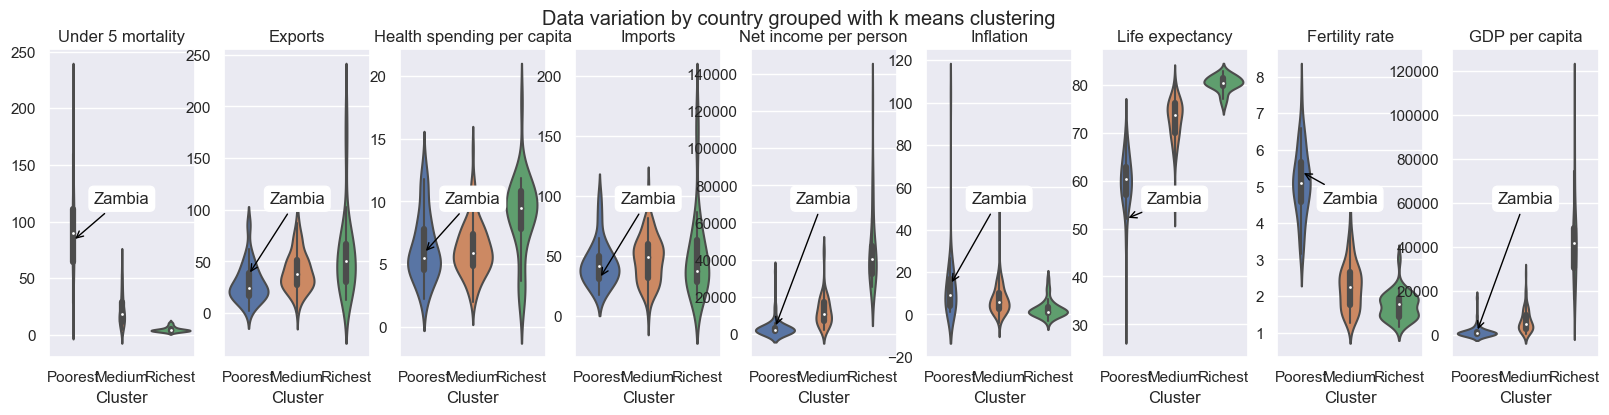

In [26]:
country='Zambia'
fig, ax = plt.subplots(1, 9, sharey=False, figsize=[20, 4])
variables = list(df.iloc[:,1:10].columns)

sns.set_style("whitegrid")
fig.suptitle('Data variation by country grouped with k means clustering')
df['selected']=""
df['selected'].loc[df['country'] == country ]='Country selected'
cluster=df.loc[:,'cluster3'][df.loc[:,'country'] == country ].values[0]


i=0
for var in variables:
    country_value=df.loc[:,var][df.loc[:,'country'] == country ].values[0]
    sns.violinplot(x="clusterfinal", y=var, data=df, ax=ax[i])
    ax[i].set_title(var)
    ax[i].set_xlabel("Cluster")
    ax[i].set_ylabel("")
#    sns.stripplot(x="clusterfinal", y=var, hue="selected", data=df, s = 3,jitter=0.05,ax=ax[i])
    ax[i].annotate(country,
            xy=(cluster, country_value), xycoords='data',
            xytext=(.5, .5), textcoords='axes fraction',
            horizontalalignment="center",
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3",
                            color="black"),
            bbox=dict(boxstyle="round", fc="w"),
            )

    ax[i].legend([],[], frameon=False)
    i+=1
plt.savefig('/Users/rebeccaharrison/Documents/Python/Bootcamp/Output/Graphs/unsupervised_labelledviolin.png')
plt.show()
            

In [30]:
df['clustercombined']=""

df.loc[(df['hiercluster3'] == 'Richest') & (df['clusterfinal'] == 'Richest'),'clustercombined']= 'Richest'
df.loc[(df['hiercluster3'] == 'Richest') & (df['clusterfinal'] != 'Richest'),'clustercombined']= 'Medium/rich'
df.loc[(df['hiercluster3'] != 'Richest') & (df['clusterfinal'] == 'Richest'),'clustercombined']= 'Medium/rich'
df.loc[(df['hiercluster3'] == 'Poorest') & (df['clusterfinal'] == 'Poorest'),'clustercombined']= 'Poorest'
df.loc[(df['hiercluster3'] != 'Poorest') & (df['clusterfinal'] == 'Poorest'),'clustercombined']= 'Poor/medium'
df.loc[(df['hiercluster3'] == 'Poorest') & (df['clusterfinal'] != 'Poorest'),'clustercombined']= 'Poor/medium'
df.loc[(df['hiercluster3'] == 'Medium') & (df['clusterfinal'] == 'Medium'),'clustercombined']='Medium'

fig2 = px.choropleth(df[['country','clustercombined']],
                    locationmode='country names',
                    locations='country',
                    title='Map of which countries are in which clusters',
                    hover_name="country",
                    color_discrete_sequence=["orange", "red", "green",'black'],color=df['clustercombined'], 
                    color_discrete_map={'Poorest':'Red',
                                        'Poor/medium': 'Orange',
                                        'Medium':'Yellow',
                                        'Medium/rich':'Green',
                                        'Richest':'Blue'} )
fig2.update_geos(fitbounds="locations", visible=True)

fig2.update_layout(legend_title_text='Labels',legend_title_side='top',title_pad_l=260,title_y=0.86)
plt.savefig('/Users/rebeccaharrison/Documents/Python/Bootcamp/Output/Graphs/unsupervised_mapcombined.png')
fig2.show(engine='kaleido')

<Figure size 640x480 with 0 Axes>

In [32]:
df['cluster2combined']=""

df.loc[(df['hiercluster2'] == 'Richest') & (df['cluster2'] == 'Richest'),'cluster2combined']= 'Richest'
df.loc[(df['hiercluster2'] == 'Richest') & (df['cluster2'] != 'Richest'),'cluster2combined']= 'Poor/rich'
df.loc[(df['hiercluster2'] != 'Richest') & (df['cluster2'] == 'Richest'),'cluster2combined']= 'Poor/rich'
df.loc[(df['hiercluster2'] == 'Poorest') & (df['cluster2'] == 'Poorest'),'cluster2combined']= 'Poorest'


fig = px.choropleth(df[['country','cluster2combined']],
                    locationmode='country names',
                    locations='country',
                    title='Combined clustering (2 clusters)',
                    hover_name="country",
                    color_discrete_sequence=["orange", "red", "green",'black'],color=df['cluster2combined'], 

                    color_discrete_map={'Poorest':'Red',
                                        'Richest':'Green',
                                        'Poor/rich':'Orange'} )
fig.update_geos(fitbounds="locations", visible=True)

fig.update_layout(legend_title_text='Labels',legend_title_side='top',title_pad_l=260,title_y=0.86)

plt.savefig('/Users/rebeccaharrison/Documents/Python/Bootcamp/Output/Graphs/unsupervised_map2clusterscombined.png')

fig.show(engine='kaleido')


<Figure size 640x480 with 0 Axes>

ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not ['Poorest' 'Richest' 'Richest' 'Poorest' 'Richest' 'Richest' 'Richest'
 'Richest' 'Richest' 'Richest' 'Richest' 'Richest' 'Richest' 'Richest'
 'Richest' 'Richest' 'Richest' 'Poorest' 'Richest' 'Richest' 'Richest'
 'Poorest' 'Richest' 'Richest' 'Richest' 'Poorest' 'Poorest' 'Richest'
 'Poorest' 'Richest' 'Richest' 'Poorest' 'Poorest' 'Richest' 'Richest'
 'Richest' 'Poorest' 'Poorest' 'Poorest' 'Richest' 'Poorest' 'Richest'
 'Richest' 'Richest' 'Richest' 'Richest' 'Richest' 'Richest' 'Richest'
 'Poorest' 'Poorest' 'Richest' 'Richest' 'Richest' 'Richest' 'Poorest'
 'Poorest' 'Richest' 'Richest' 'Poorest' 'Richest' 'Richest' 'Richest'
 'Poorest' 'Poorest' 'Richest' 'Poorest' 'Richest' 'Richest' 'Richest'
 'Richest' 'Richest' 'Poorest' 'Richest' 'Richest' 'Richest' 'Richest'
 'Richest' 'Richest' 'Richest' 'Poorest' 'Poorest' 'Richest' 'Richest'
 'Poorest' 'Richest' 'Richest' 'Poorest' 'Poorest' 'Richest' 'Richest'
 'Richest' 'Richest' 'Poorest' 'Poorest' 'Richest' 'Richest' 'Poorest'
 'Richest' 'Poorest' 'Richest' 'Richest' 'Richest' 'Richest' 'Richest'
 'Richest' 'Poorest' 'Poorest' 'Poorest' 'Richest' 'Richest' 'Richest'
 'Poorest' 'Poorest' 'Richest' 'Richest' 'Poorest' 'Richest' 'Richest'
 'Richest' 'Richest' 'Richest' 'Richest' 'Richest' 'Richest' 'Richest'
 'Poorest' 'Richest' 'Richest' 'Poorest' 'Richest' 'Richest' 'Poorest'
 'Richest' 'Richest' 'Richest' 'Poorest' 'Poorest' 'Richest' 'Richest'
 'Richest' 'Richest' 'Poorest' 'Richest' 'Richest' 'Richest' 'Poorest'
 'Poorest' 'Richest' 'Poorest' 'Poorest' 'Richest' 'Richest' 'Richest'
 'Richest' 'Poorest' 'Richest' 'Richest' 'Richest' 'Richest' 'Richest'
 'Richest' 'Poorest' 'Richest' 'Richest' 'Poorest' 'Poorest']

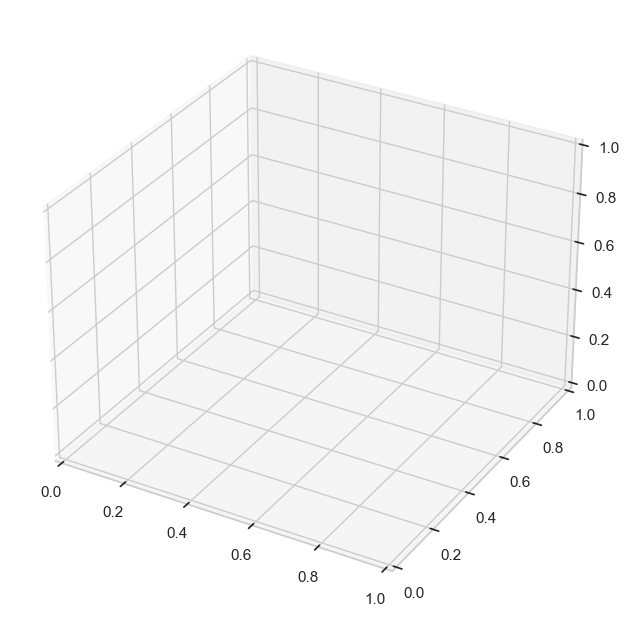

In [56]:
x1 = df['Under 5 mortality']
y2 = df['Fertility rate']
z3 = df['Life expectancy']

x4 = df['Net income per person']
y5 = df['Inflation']
z6 = df['GDP per capita']

x7 = df['Exports']
y8 = df['Imports']
z9 = df['Health spending per capita']

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
#cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(x1, y2, z3, s=40, marker='o', c=df["cluster2"], alpha=1)
ax.set_xlabel('Under 5 mortality')
ax.set_ylabel('Fertility rate')
ax.set_zlabel('Life expectancy')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
#cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(x4, y5, z6, s=40, marker='o', c=df["cluster2"], alpha=1)
ax.set_xlabel('Exports')
ax.set_ylabel('Imports')
ax.set_zlabel('Health spending per capita')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
#cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())

# plot
sc = ax.scatter(x7, y8, z9, s=40, marker='o', c=df["cluster2"], alpha=1)
ax.set_xlabel('Under 5 mortality')
ax.set_ylabel('Fertility rate')
ax.set_zlabel('Life expectancy')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')

In [35]:
prs = Presentation('/Users/rebeccaharrison/Documents/Python/Bootcamp/Output/template.pptx')

# Slide 1 - title
slide = prs.slides.add_slide(prs.slide_layouts[0]) #slide_layout[0] is title slide in template selected
title = slide.shapes.title
subtitle = slide.placeholders[1]

title.text = "Unsupervised learning"
subtitle.text = "Which countries are eligible for aid?"

from pptx.util import Inches

# slide 2
img_path_1 = '/Users/rebeccaharrison/Documents/Python/Bootcamp/Output/Graphs/unsupervised_corr.png'
slide = prs.slides.add_slide(prs.slide_layouts[5]) #slide_layout[5] is the 6th in the template selected

title = slide.shapes.title

title.text = "Data exploration"

left = Inches(2)
top = Inches(7)
height = Inches(3)
width = Inches(4)
txBox = slide.shapes.add_textbox(left, top, width, height)
tf = txBox.text_frame
tf.text = "Imports and Exports are highly correlated"


left = top = Inches(2)
pic = slide.shapes.add_picture(img_path_1, left, top)

# slide 3
img_path_2 = '/Users/rebeccaharrison/Documents/Python/Bootcamp/Output/Graphs/unsupervised_elbow1.png'
slide = prs.slides.add_slide(prs.slide_layouts[5]) #slide_layout[5] is the 6th in the template selected

title = slide.shapes.title

title.text = "Elbow chart to indicate ideal number of clusters"

left = Inches(2)
top = Inches(7)
txBox = slide.shapes.add_textbox(left, top, width, height)
tf = txBox.text_frame
tf.text = "Indication that 2, 3 or 4 clusters are ideal, 3 looks best"

left = top = Inches(2)
pic = slide.shapes.add_picture(img_path_2, left, top)

# slide 4
img_path_3 = '/Users/rebeccaharrison/Documents/Python/Bootcamp/Output/Graphs/unsupervised_scatter3clusters.png'
slide = prs.slides.add_slide(prs.slide_layouts[5]) #slide_layout[5] is the 6th in the template selected

title = slide.shapes.title

title.text = "Inspecting the output of the 3 cluster k means clustering"

left = Inches(2)
top = Inches(7)
txBox = slide.shapes.add_textbox(left, top, width, height)
tf = txBox.text_frame
tf.text = "Scatter charts show that 3 clusters looks sensible"

left = top = Inches(2)
pic = slide.shapes.add_picture(img_path_3, left, top)

# slide 5
img_path_4 = '/Users/rebeccaharrison/Documents/Python/Bootcamp/Output/Graphs/unsupervised_scatter4clusters.png'
slide = prs.slides.add_slide(prs.slide_layouts[5]) #slide_layout[5] is the 6th in the template selected

title = slide.shapes.title

title.text = "k means 4 clusters"

left = Inches(2)
top = Inches(7)
txBox = slide.shapes.add_textbox(left, top, width, height)
tf = txBox.text_frame
tf.text = "4th cluster doesn't add much useful information - just indicates the high export/importers"

left = top = Inches(2)
pic = slide.shapes.add_picture(img_path_4, left, top)

# slide 6
img_path_5 = '/Users/rebeccaharrison/Documents/Python/Bootcamp/Output/Graphs/unsupervised_scatter2clusters.png'
slide = prs.slides.add_slide(prs.slide_layouts[5]) #slide_layout[5] is the 6th in the template selected

title = slide.shapes.title

title.text = "k means 2 clusters"

left = Inches(2)
top = Inches(7)

txBox = slide.shapes.add_textbox(left, top, width, height)
tf = txBox.text_frame
tf.text = "2 clusters looks quite useful to specifically answer the question of which countries are eligible for aid"

left = top = Inches(2)
pic = slide.shapes.add_picture(img_path_5, left, top)

# slide 7
img_path_6 = '/Users/rebeccaharrison/Documents/Python/Bootcamp/Output/Graphs/unsupervised_mapcombined.png'
slide = prs.slides.add_slide(prs.slide_layouts[5]) #slide_layout[5] is the 6th in the template selected

title = slide.shapes.title

title.text = "But what do hierarchical clusters give us?"

left = Inches(2)
top = Inches(7)
txBox = slide.shapes.add_textbox(left, top, width, height)
tf = txBox.text_frame
tf.text = "Quite similar results - just a few countries are classed differently"

left = top = Inches(2)
pic = slide.shapes.add_picture(img_path_6, left, top)

# slide 8
img_path_7 = '/Users/rebeccaharrison/Documents/Python/Bootcamp/Output/Graphs/unsupervised_map2clusterscombined.png'
slide = prs.slides.add_slide(prs.slide_layouts[5]) #slide_layout[5] is the 6th in the template selected

title = slide.shapes.title

title.text = "Map of 2 clusters"

left = Inches(2)
top = Inches(7)
txBox = slide.shapes.add_textbox(left, top, width, height)
tf = txBox.text_frame
tf.text = ""

left = top = Inches(2)
pic = slide.shapes.add_picture(img_path_7, left, top)

# slide 9
img_path_8 = '/Users/rebeccaharrison/Documents/Python/Bootcamp/Output/Graphs/unsupervised_dendrogram.png'
img_path_9 = '/Users/rebeccaharrison/Documents/Python/Bootcamp/Output/Graphs/unsupervised_hierclusters.png'
slide = prs.slides.add_slide(prs.slide_layouts[5]) #slide_layout[5] is the 6th in the template selected

title = slide.shapes.title

title.text = "How many clusters are ideal for hierarchical clusters?"

left = Inches(2)
top = Inches(7)
txBox = slide.shapes.add_textbox(left, top, width, height)
tf = txBox.text_frame
tf.text = ""

left = top = Inches(2)
pic = slide.shapes.add_picture(img_path_8, left, top)
pic = slide.shapes.add_picture(img_path_9, left, top)

# slide 10
img_path = '/Users/rebeccaharrison/Documents/Python/Bootcamp/Output/Graphs/unsupervised_labelledviolin.png'
slide = prs.slides.add_slide(prs.slide_layouts[5]) #slide_layout[5] is the 6th in the template selected

title = slide.shapes.title

title.text = "Here is a summary of results with an example country"

left = Inches(2)
top = Inches(7)
height = Inches(3)
width = Inches(4)
txBox = slide.shapes.add_textbox(left, top, width, height)
tf = txBox.text_frame
tf.text = "You can pick out the country and see how it compares"

left = top = Inches(2)
pic = slide.shapes.add_picture(img_path, left, top)



prs.save('/Users/rebeccaharrison/Documents/Python/Bootcamp/Output/week_8_presentation.pptx')